In [1]:
# Import necessary libraries
import time
from math import sqrt
import os

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display

from xgboost import XGBRegressor

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import Binarizer, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set(font='serif', style='ticks')
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif']=['Arial Unicode MS']

plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns',None)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, RepeatVector, TimeDistributed, Dense

In [2]:
# Load data
data = pd.read_csv('./Vm.csv')
X = data[['PSI', 'DELTA']]
Y = data[['n', 'k']]

In [4]:
# Standardize the data.
transfer1 = StandardScaler()
X = transfer1.fit_transform(X)

transfer2 = StandardScaler()
Y = transfer2.fit_transform(Y)

In [5]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = X.shape[0] // samples_per_slice
feature_slices_X = X[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
x = np.stack(feature_slices_X, axis=0)
samples_per_slice = 701
n_samples = Y.shape[0] // samples_per_slice
feature_slices_Y = Y[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
y = np.stack(feature_slices_Y, axis=0)

(606, 701, 2)


In [ ]:
# Split the data into training and testing sets.
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=24,shuffle=True)

In [ ]:
def create_model(trial):
    sequence_length = 701
    feature_dim = 2

    # Select a setting range for the hyperparameter
    optimizer_type = trial.suggest_categorical('optimizer', ['Adam','Adamax', 'Nadam'])
    l2_strength = trial.suggest_float('l2_strength', 1e-20, 1e-1, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-10, 1e-1, log=True)

    # Building model
    encoder_inputs = Input(shape=(sequence_length, feature_dim))
    encoder = GRU(64, return_state=True,  kernel_regularizer=l2(l2_strength))
    encoder_outputs, state_h = encoder(encoder_inputs)
    encoder_states = [state_h]

    decoder = GRU(64, return_sequences=True,  kernel_regularizer=l2(l2_strength))
    decoder_inputs = RepeatVector(sequence_length)(encoder_outputs)
    decoder_outputs = decoder(decoder_inputs, initial_state=encoder_states)

    decoder_dense = TimeDistributed(Dense(feature_dim))
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model(encoder_inputs, decoder_outputs)

    # Selection optimizer
    optimizer = {'Adam': Adam,'Adamax':Adamax, 'Nadam':Nadam}[optimizer_type](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    # create models
    model = create_model(trial)

    # EarlyStopping parameter
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    patience = trial.suggest_int('patience', 5, 70)
    validation_split = trial.suggest_float('validation_split', 0.1, 0.7)
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1, min_delta=0.0001)]
    history = model.fit(x_train, y_train, callbacks=callbacks, epochs=300, batch_size=batch_size, validation_split=validation_split)

    return min(history.history['val_loss'])
    
# Create a study object
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=37)

# Print optimum parameter
print(study.best_trial)

In [ ]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)

# Prints all parameters and values
print("All params and values:")
for trial in study.trials:
    print("Trial #{}: params={}, value={}".format(trial.number, trial.params, trial.value))

In [180]:
# Build the model according to the best parameters
l2_reg = l2(5.267017855963752e-10)

sequence_length = 701
feature_dim = 2

encoder_inputs = Input(shape=(sequence_length, feature_dim))

# Encoder
encoder = GRU(64, return_state=True, kernel_regularizer=l2_reg)
encoder_outputs, state_h = encoder(encoder_inputs)
encoder_states = [state_h]

# Decoder
decoder = GRU(64, return_sequences=True, kernel_regularizer=l2_reg)
decoder_inputs = RepeatVector(sequence_length)(encoder_outputs)
decoder_outputs = decoder(decoder_inputs, initial_state=encoder_states)

decoder_dense = TimeDistributed(Dense(feature_dim))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model(encoder_inputs, decoder_outputs)

# Output model structure
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 701, 2)]             0         []                            
                                                                                                  
 gru_16 (GRU)                [(None, 64),                 13056     ['input_9[0][0]']             
                              (None, 64)]                                                         
                                                                                                  
 repeat_vector_8 (RepeatVec  (None, 701, 64)              0         ['gru_16[0][0]']              
 tor)                                                                                             
                                                                                            

In [181]:
# Define early stopping callback.
callbacks = [EarlyStopping(monitor='val_loss', patience=17, verbose=1, min_delta=0.00001)]

In [182]:
# Compilation model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0011985512161692866))

# Training model
history = model.fit(x_train, y_train, callbacks=callbacks,epochs=1000, batch_size=128, validation_split=0.49476893486914786)

Epoch 1/1000
2/2 [==============================] - 12s 4s/step - loss: 1.0206 - val_loss: 0.9831
Epoch 2/1000
2/2 [==============================] - 8s 4s/step - loss: 1.0139 - val_loss: 0.9815
Epoch 3/1000
2/2 [==============================] - 8s 5s/step - loss: 1.0128 - val_loss: 0.9767
Epoch 4/1000
2/2 [==============================] - 7s 4s/step - loss: 1.0092 - val_loss: 0.9745
Epoch 5/1000
2/2 [==============================] - 8s 4s/step - loss: 1.0082 - val_loss: 0.9740
Epoch 6/1000
2/2 [==============================] - 8s 4s/step - loss: 1.0067 - val_loss: 0.9742
Epoch 7/1000
2/2 [==============================] - 16s 11s/step - loss: 1.0048 - val_loss: 0.9751
Epoch 8/1000
2/2 [==============================] - 21s 10s/step - loss: 1.0037 - val_loss: 0.9769
Epoch 9/1000
2/2 [==============================] - 21s 10s/step - loss: 1.0034 - val_loss: 0.9781
Epoch 10/1000
2/2 [==============================] - 22s 12s/step - loss: 1.0031 - val_loss: 0.9778
Epoch 11/1000
2/2 [=

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Predictive test set
y_pred = model.predict(x_test)
# Adjust back to two column shapes
y_pred_reshaped = y_pred.reshape(-1, 2)
print(y_pred_reshaped.shape)
y_test_reshaped = y_test.reshape(-1, 2)
print(y_test_reshaped.shape)

4/4 [==============================] - 1s 109ms/step
(85522, 2)
(85522, 2)


In [10]:
# Restore the normalized output to the original value
y_pred_reshaped = transfer2.inverse_transform(y_pred_reshaped)
y_test_reshaped = transfer2.inverse_transform(y_test_reshaped)

In [11]:
# Extract the first and second columns
n_pred = y_pred_reshaped[:, 0]
n_test = y_test_reshaped[:, 0]
k_pred = y_pred_reshaped[:, 1]
k_test = y_test_reshaped[:, 1]

print(n_pred.shape)  
print(n_test.shape)  
print(k_pred.shape) 
print(k_test.shape)

(85522,)
(85522,)
(85522,)
(85522,)


In [13]:
# Calculate the loss of n
mse = mean_squared_error(n_test, n_pred)
print("n_test MSE: ", mse)
rmse = np.sqrt(mse)
print("n_test RMSE: ", rmse)
mae = mean_absolute_error(n_test, n_pred)
print("n_test MAE: ", mae)
r2 = r2_score(n_test, n_pred)
print("n_test R2 score: ", r2)

n_test MSE:  0.01007886294541231
n_test RMSE:  0.10039354035699861
n_test MAE:  0.07146309079401063
n_test R2 score:  0.8519595048240932


In [14]:
# Calculate the loss of k
mse = mean_squared_error(k_test, k_pred)
print("k_test MSE: ", mse)
rmse = np.sqrt(mse)
print("k_test RMSE: ", rmse)
mae = mean_absolute_error(k_test, k_pred)
print("k_test MAE: ", mae)
r2 = r2_score(k_test, k_pred)
print("k_test R2 score: ", r2)

k_test MSE:  0.0030075371535587024
k_test RMSE:  0.05484101707261366
k_test MAE:  0.02292303133745993
k_test R2 score:  0.9810187939945904


In [15]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = n_pred.shape[0] // samples_per_slice
feature_slices_pred = n_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_pred = np.stack(feature_slices_pred, axis=0)
print(n_pred.shape) 

samples_per_slice = 701
n_samples = n_test.shape[0] // samples_per_slice
feature_slices_test = n_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_test = np.stack(feature_slices_test, axis=0)
print(n_test.shape)

samples_per_slice = 701
n_samples = k_pred.shape[0] // samples_per_slice
feature_slices_pred = k_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_pred = np.stack(feature_slices_pred, axis=0)
print(k_pred.shape) 

samples_per_slice = 701
n_samples = k_test.shape[0] // samples_per_slice
feature_slices_test = k_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_test = np.stack(feature_slices_test, axis=0)
print(k_test.shape)

(122, 701, 1)
(122, 701, 1)
(122, 701, 1)
(122, 701, 1)


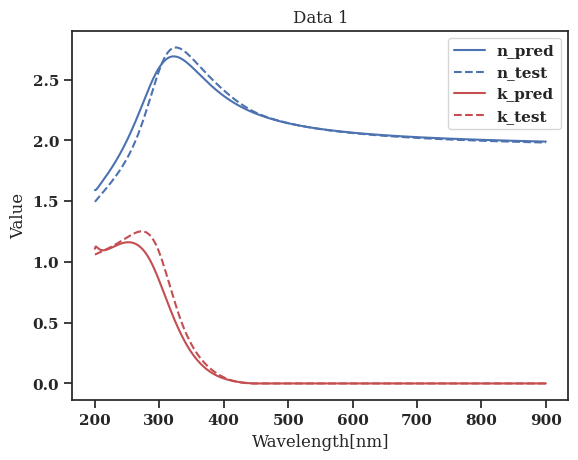

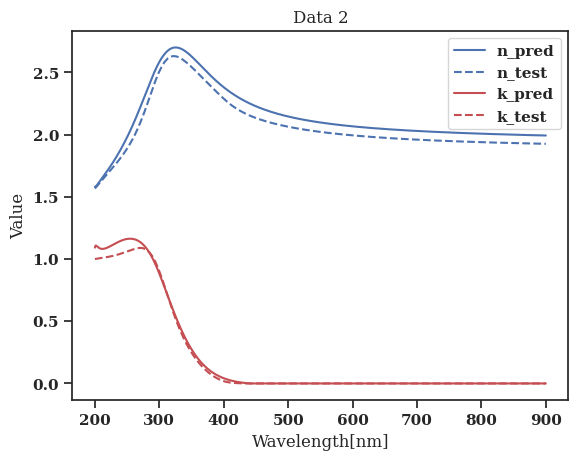

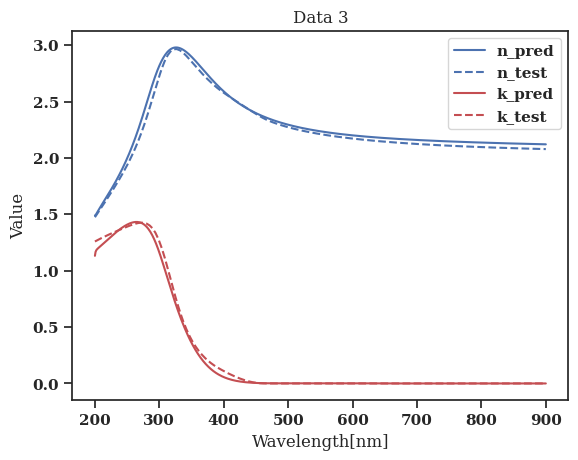

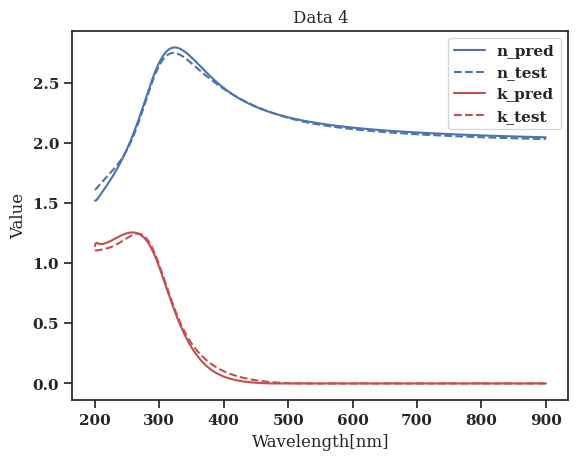

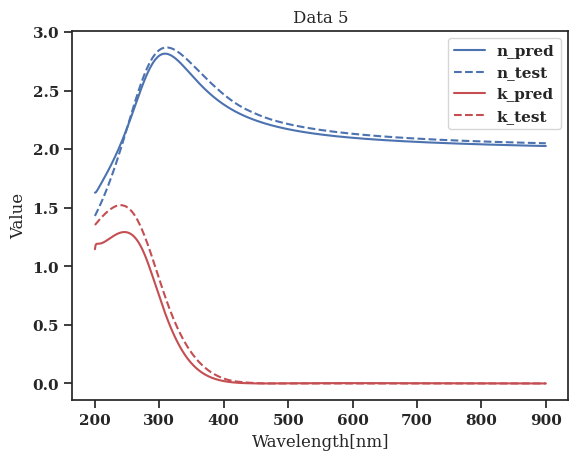

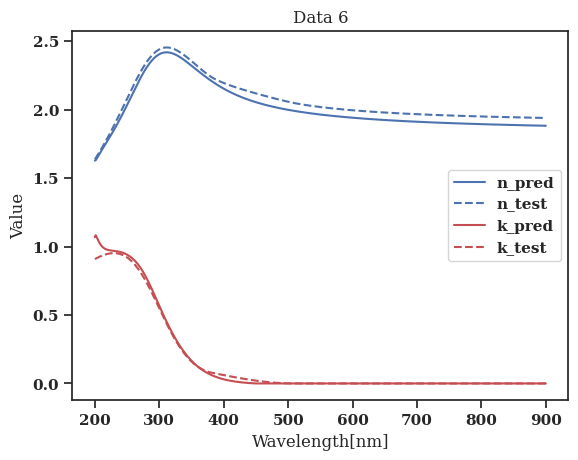

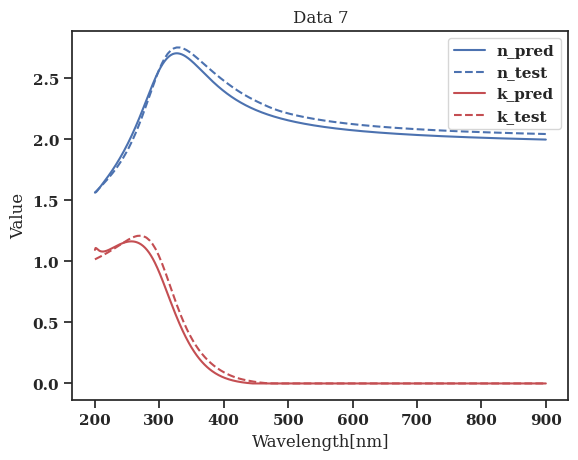

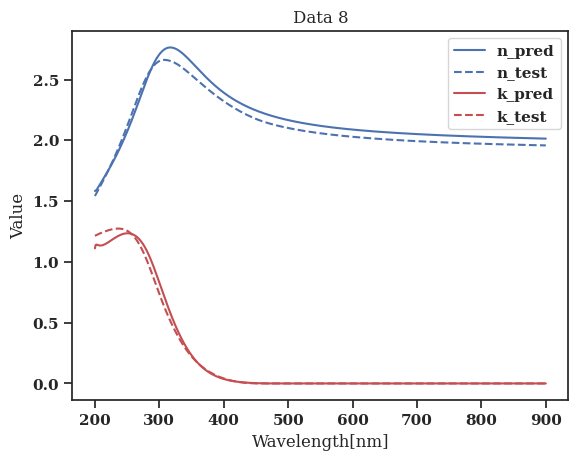

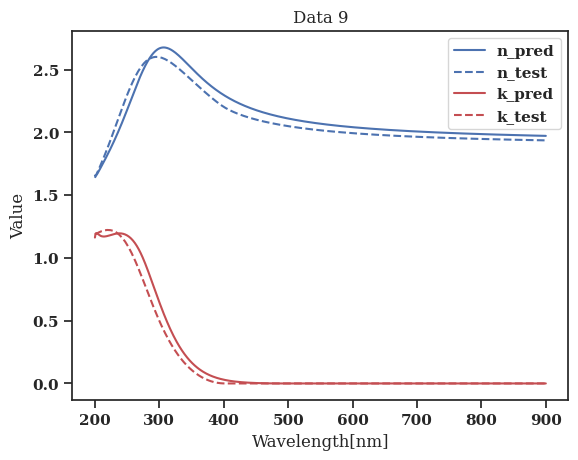

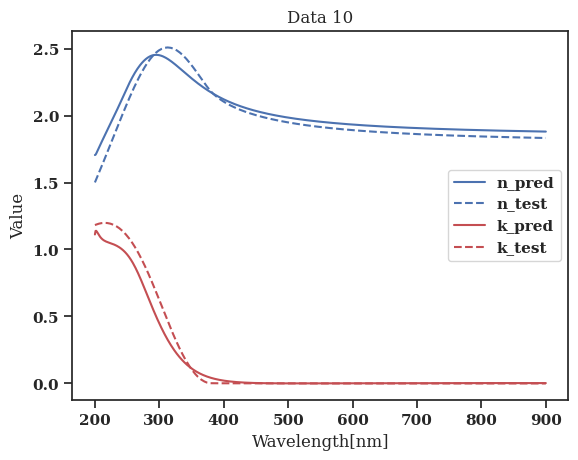

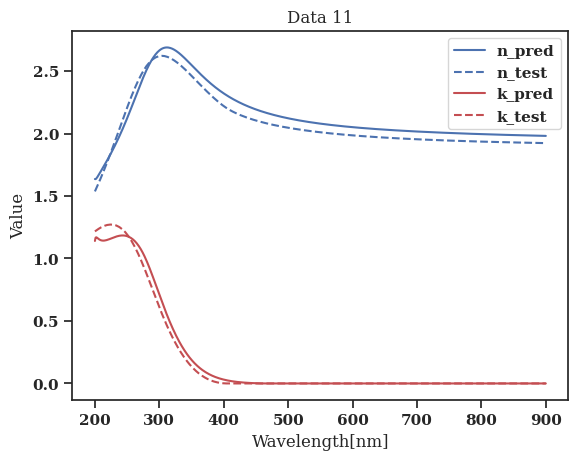

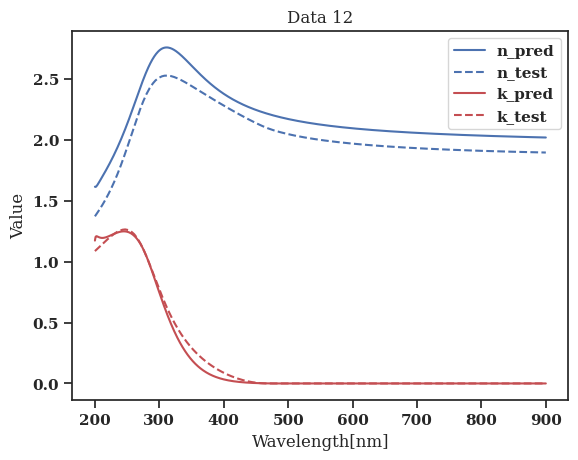

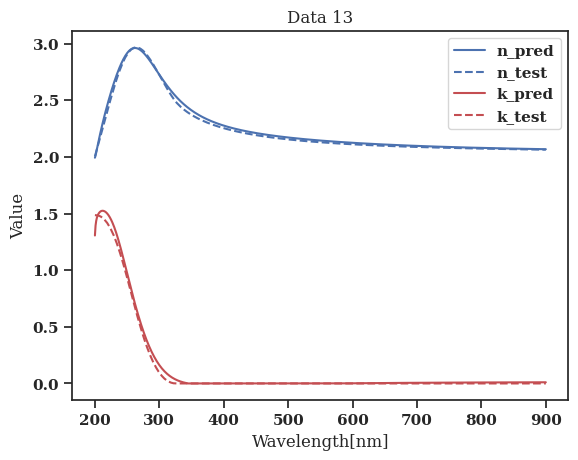

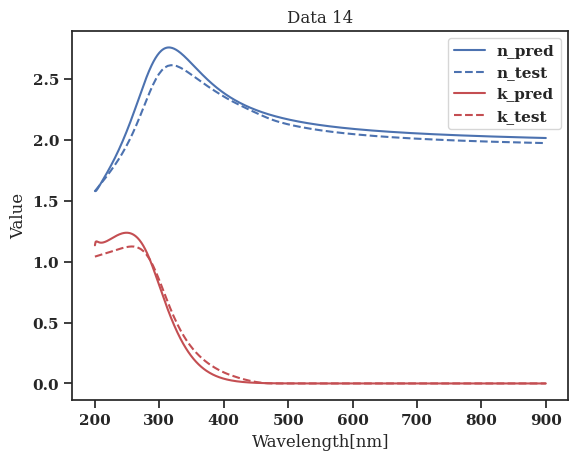

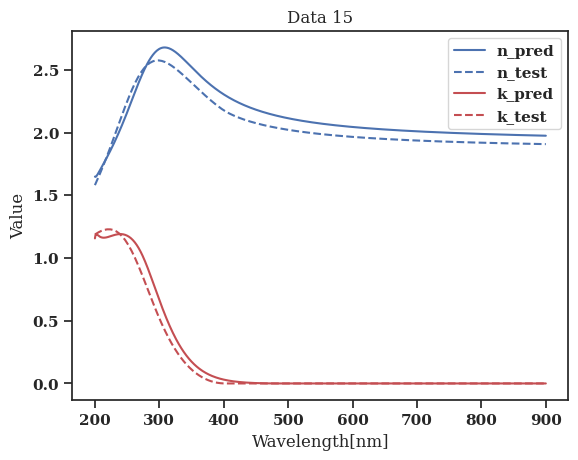

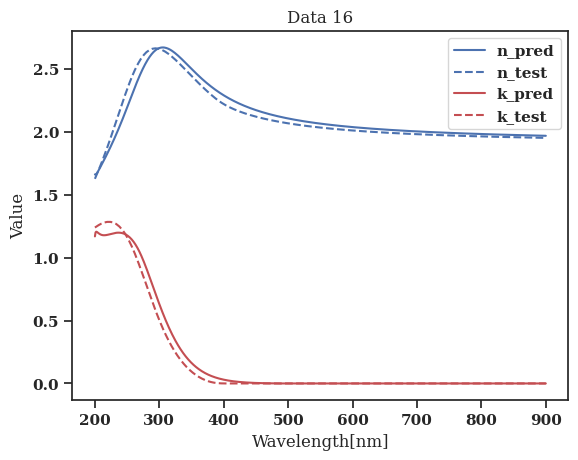

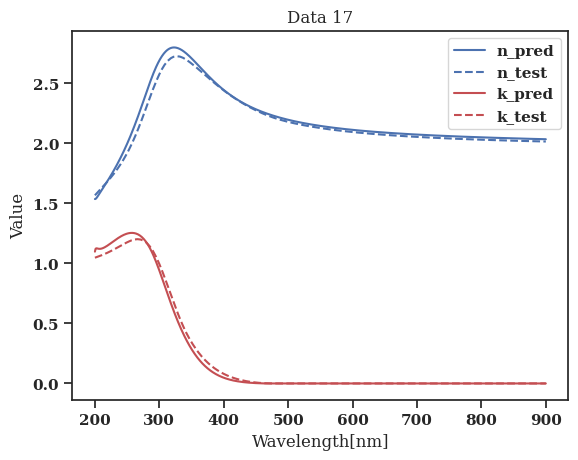

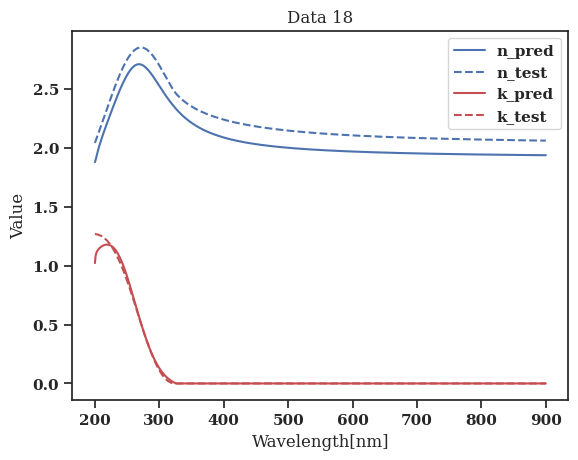

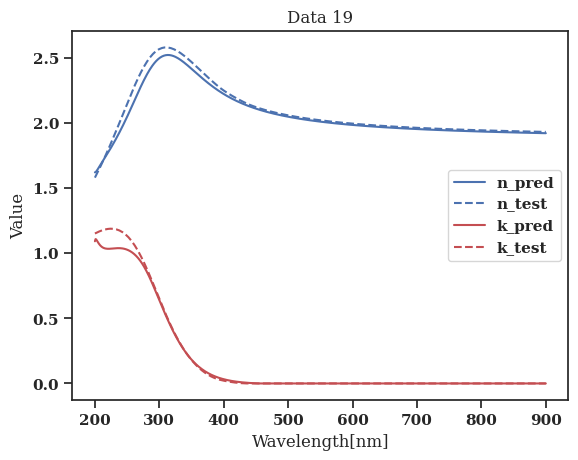

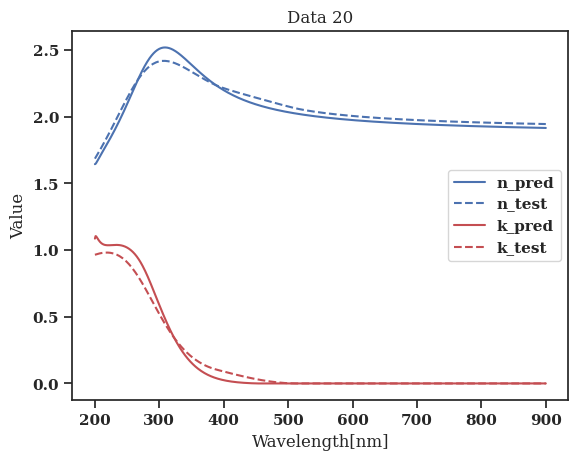

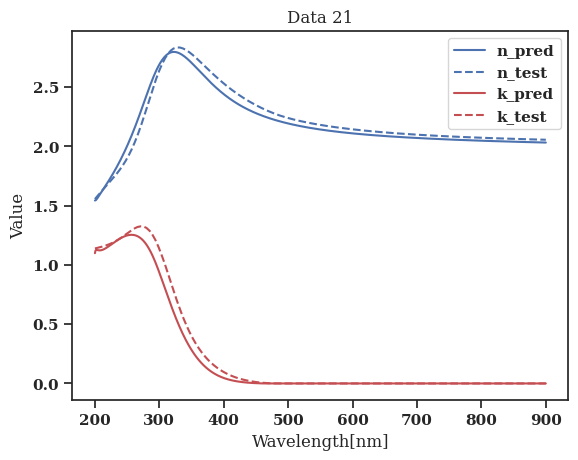

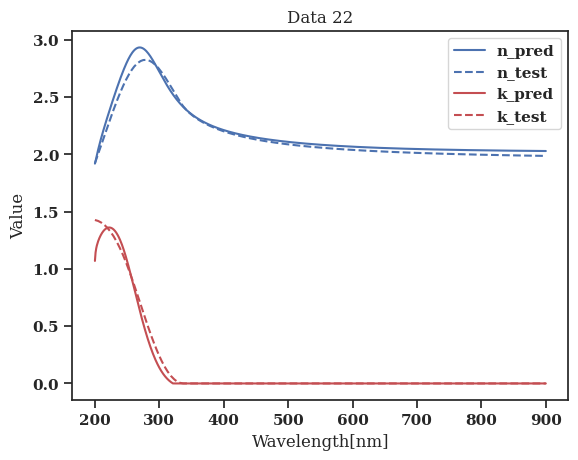

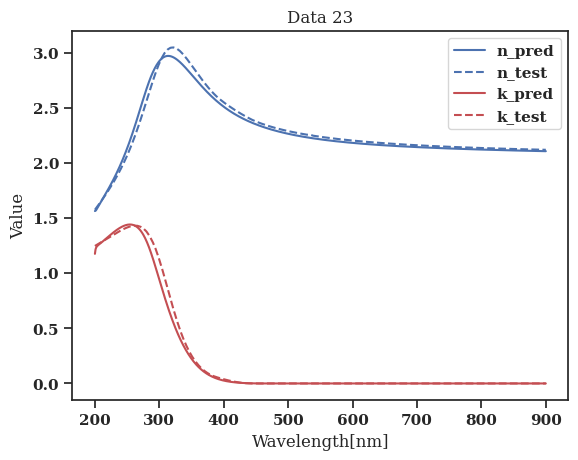

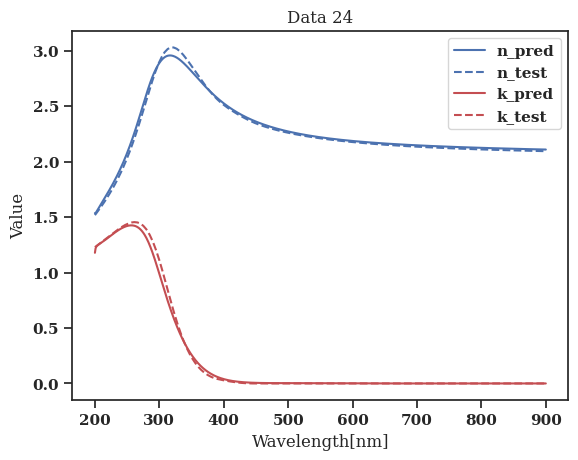

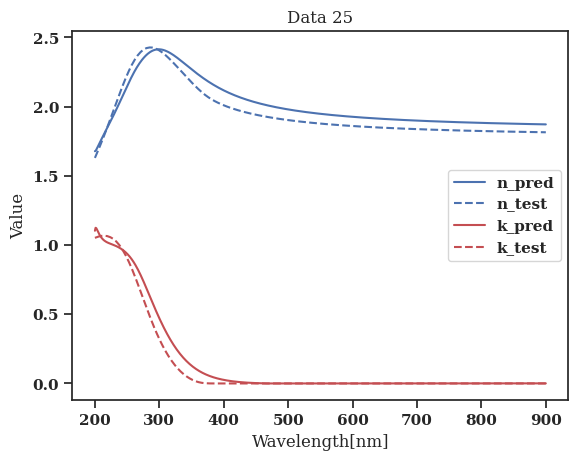

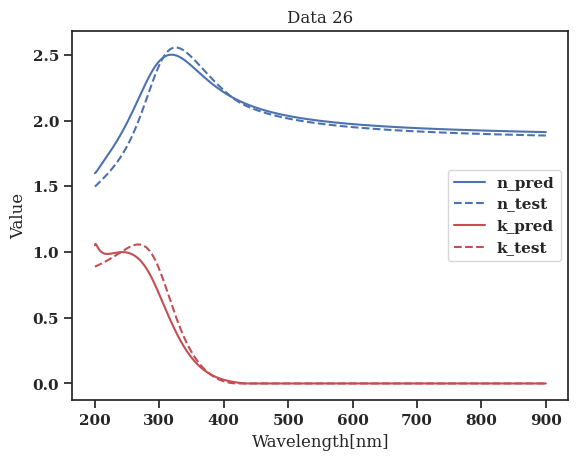

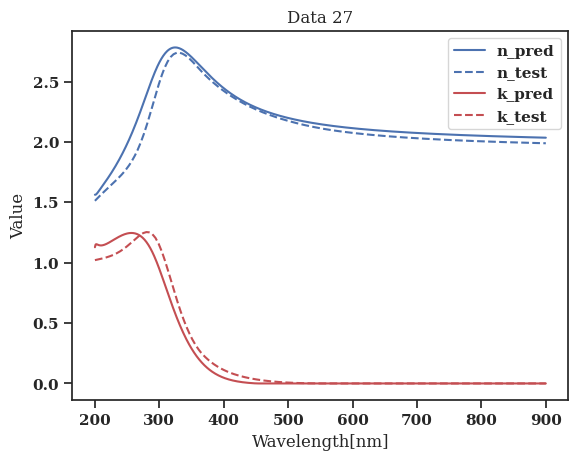

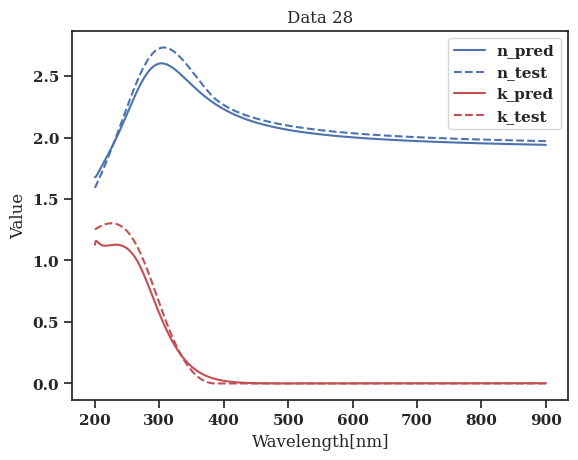

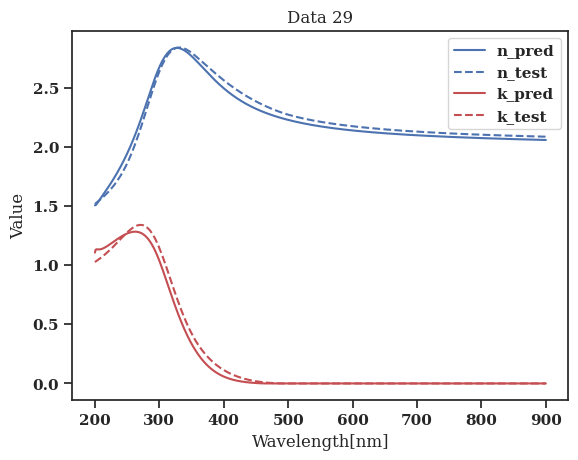

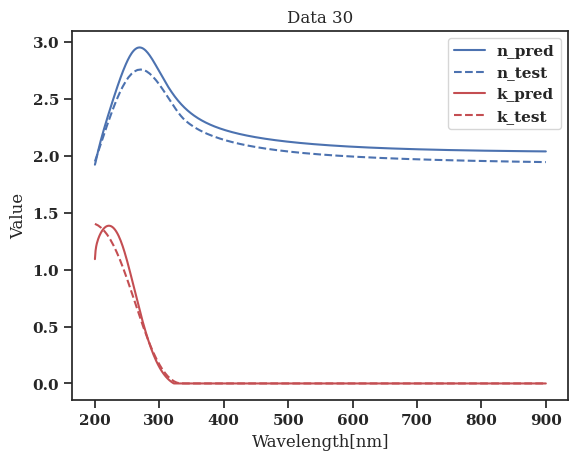

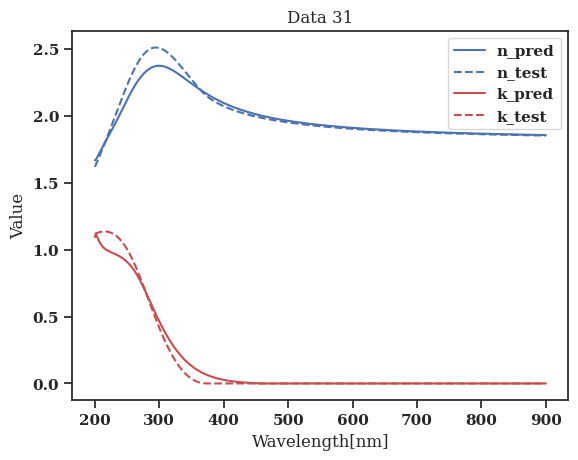

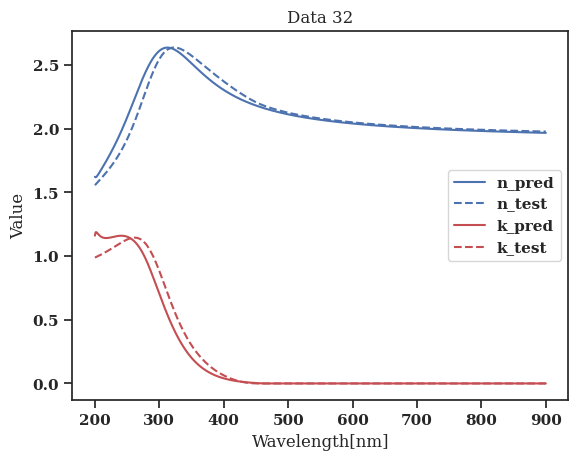

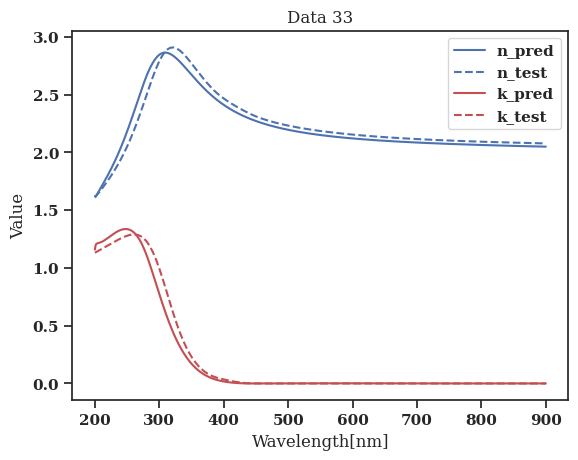

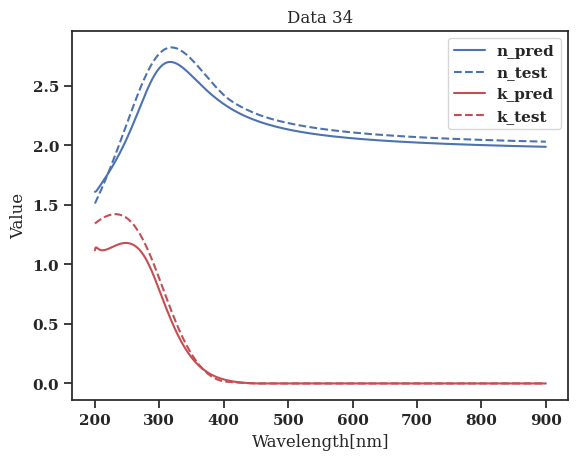

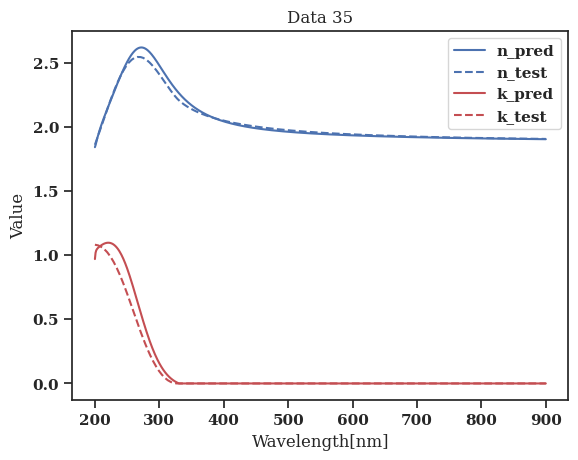

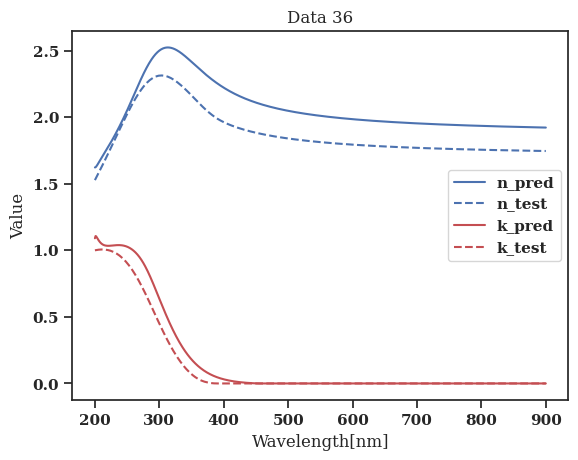

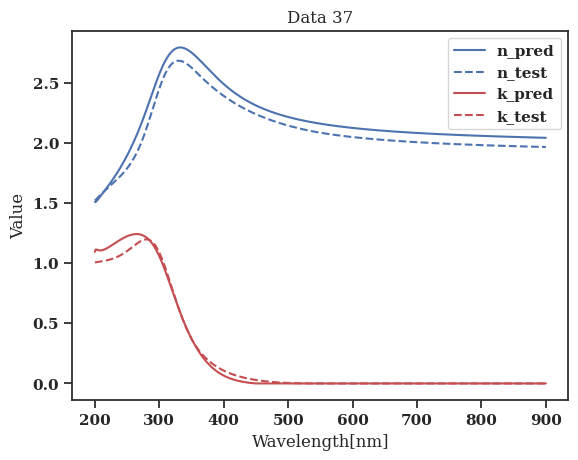

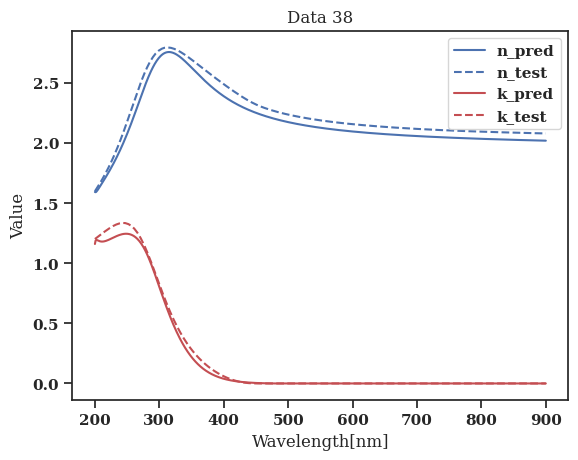

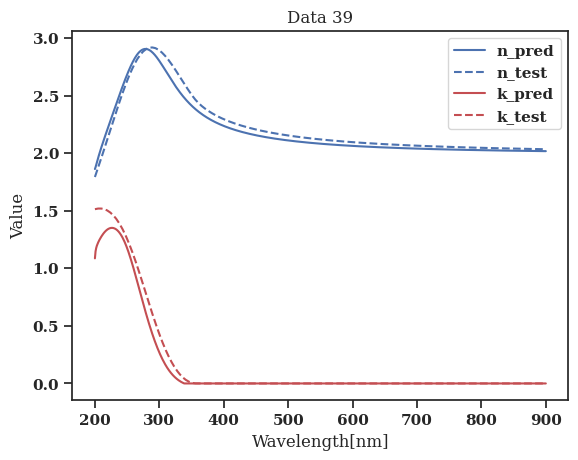

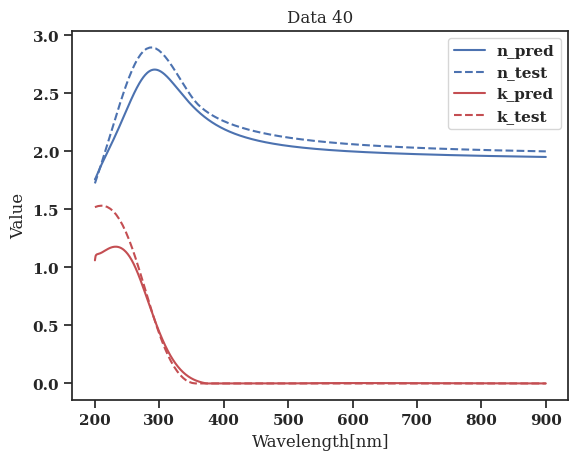

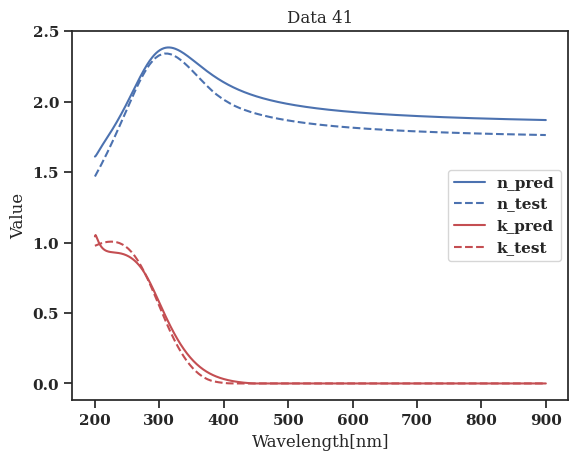

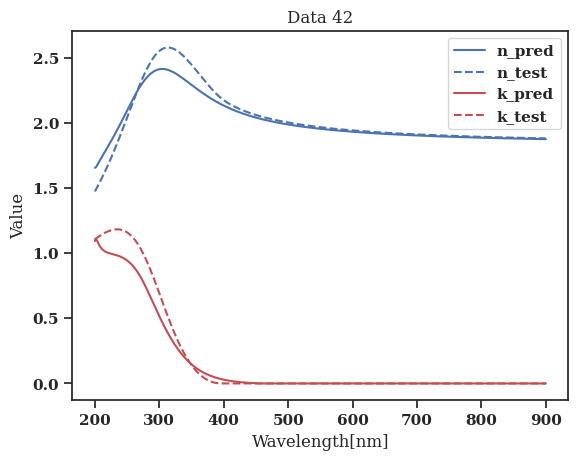

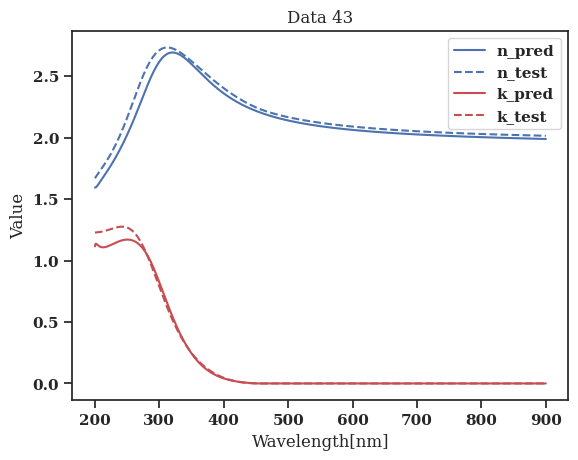

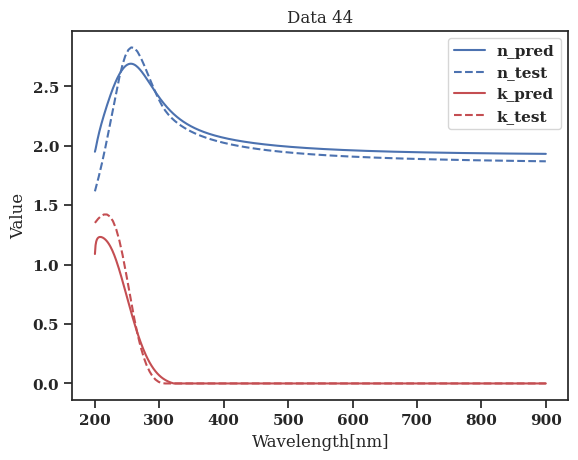

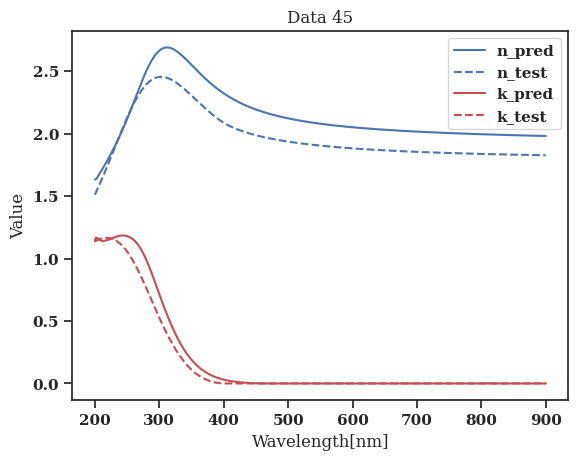

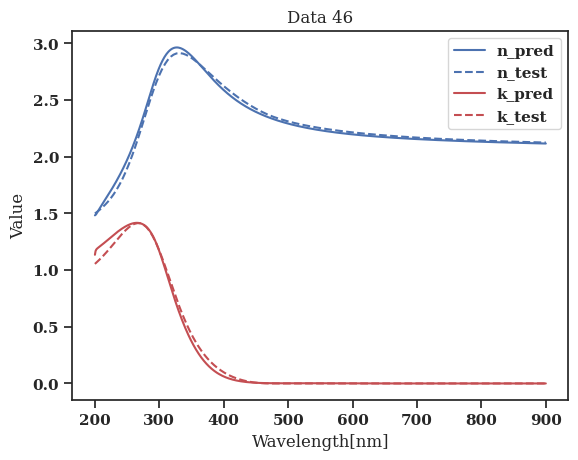

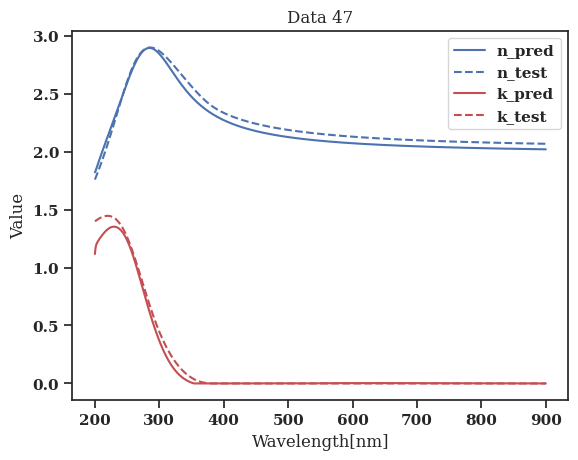

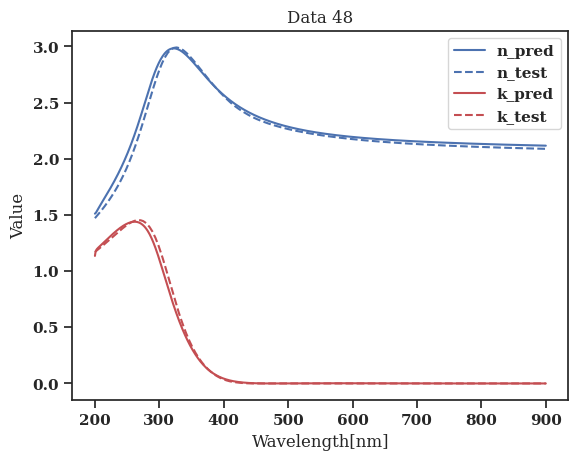

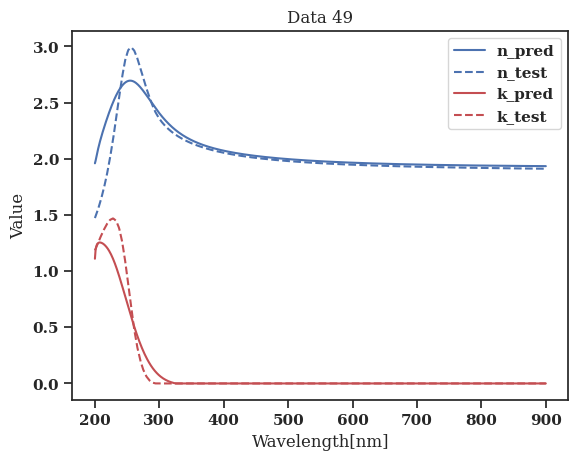

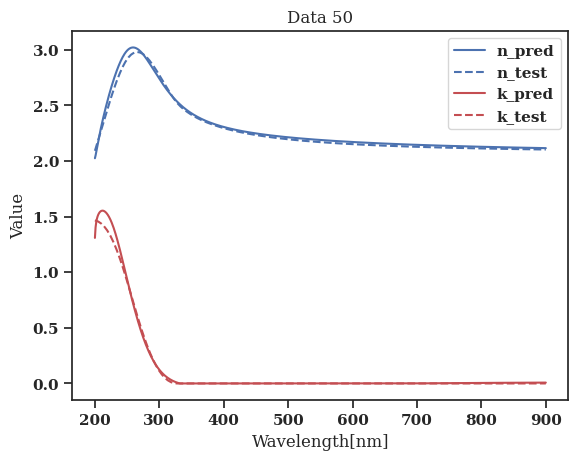

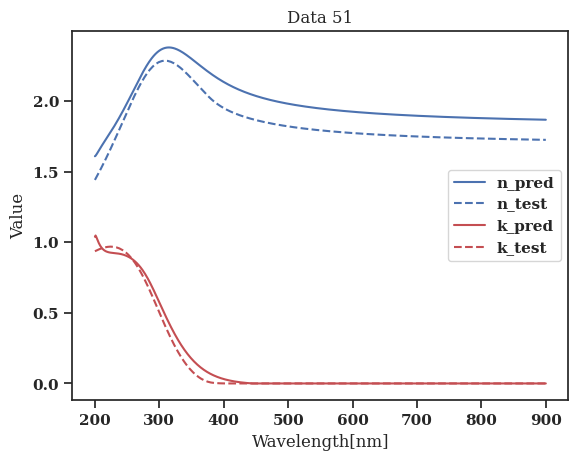

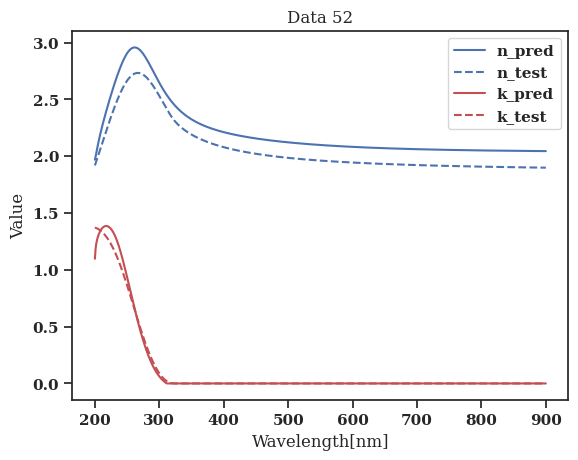

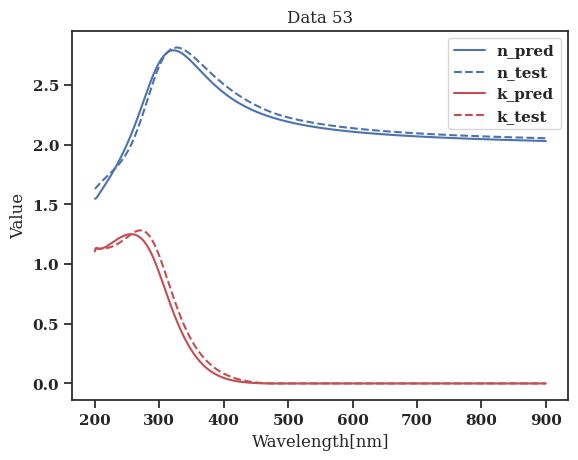

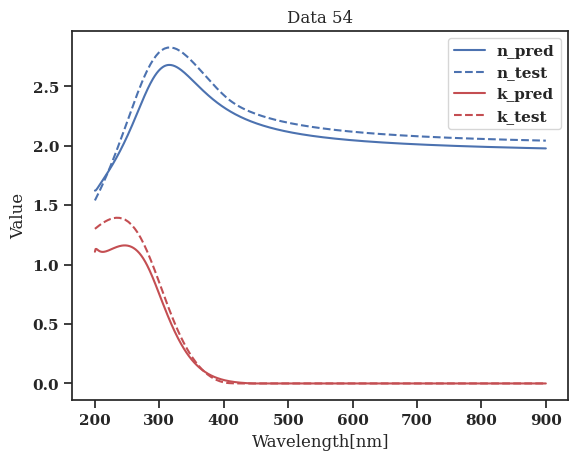

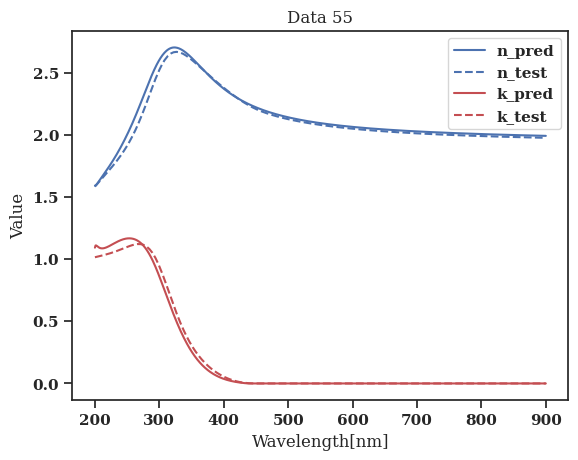

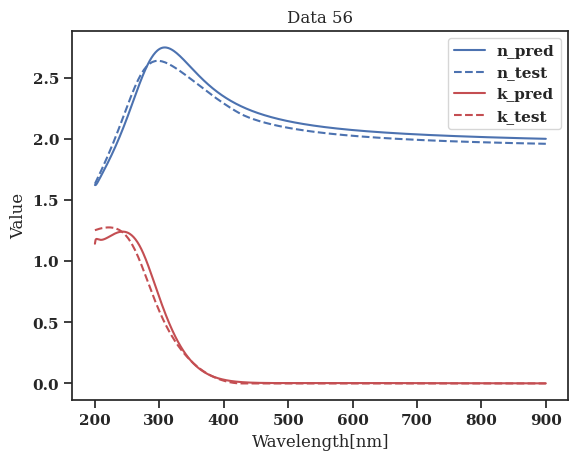

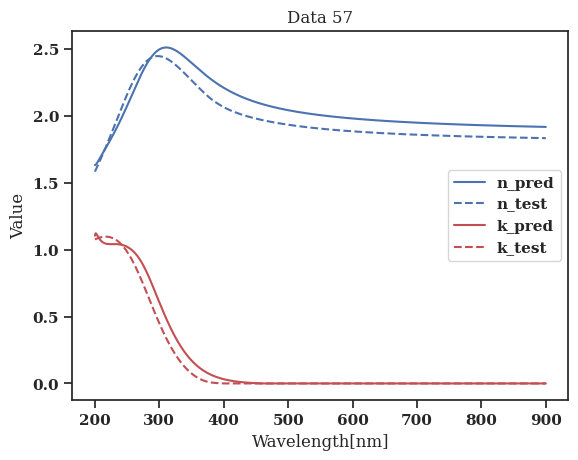

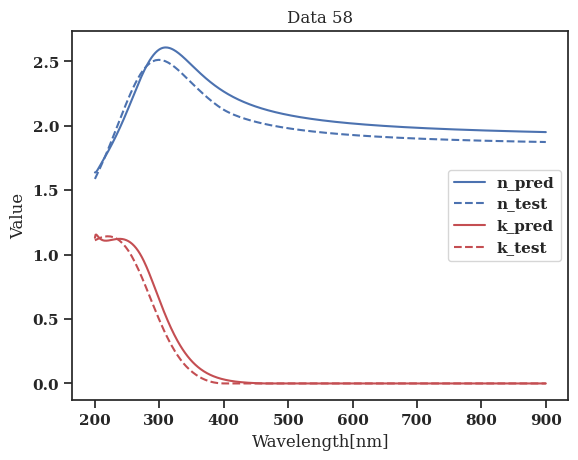

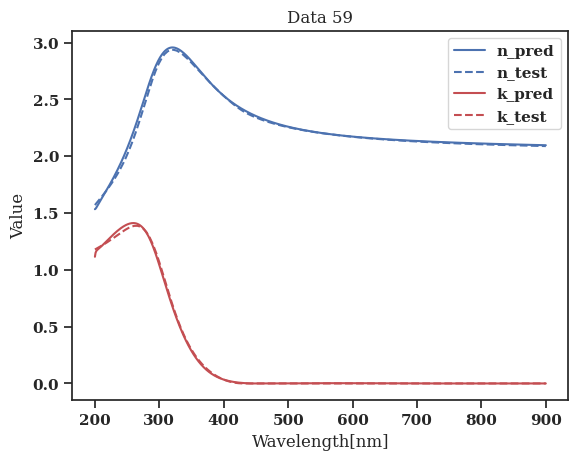

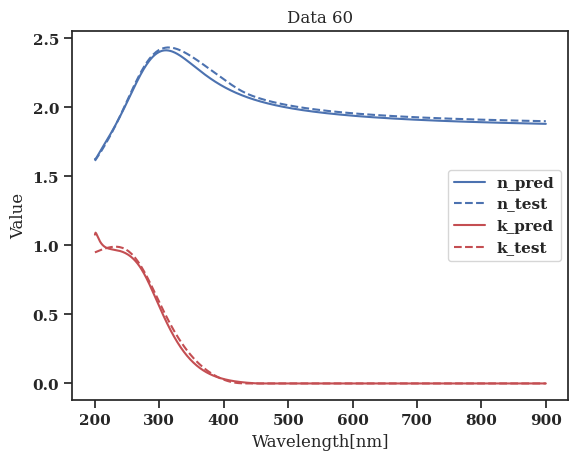

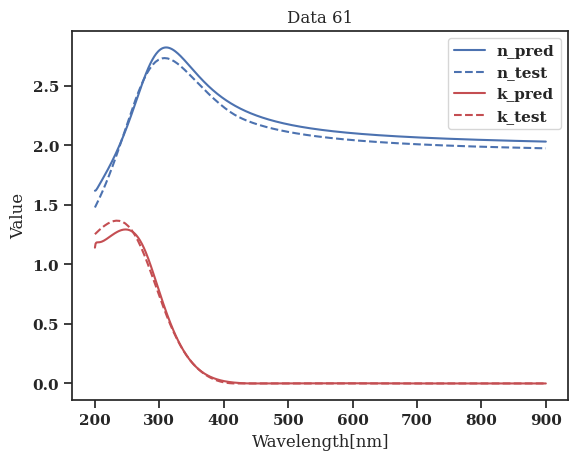

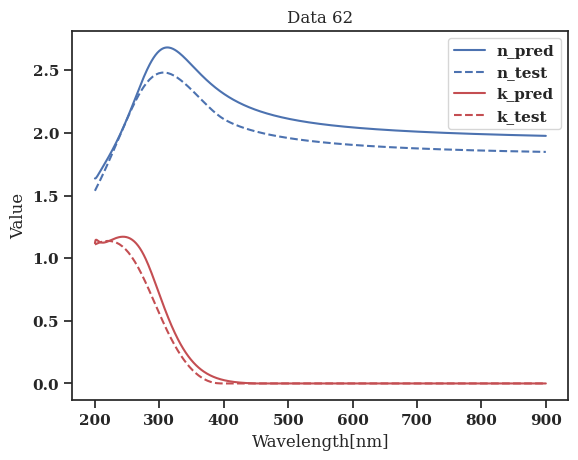

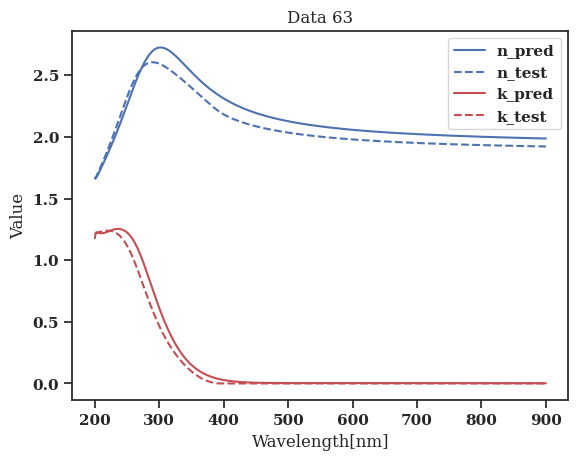

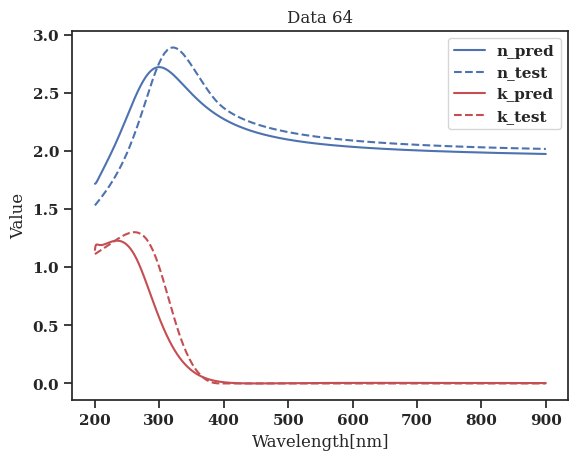

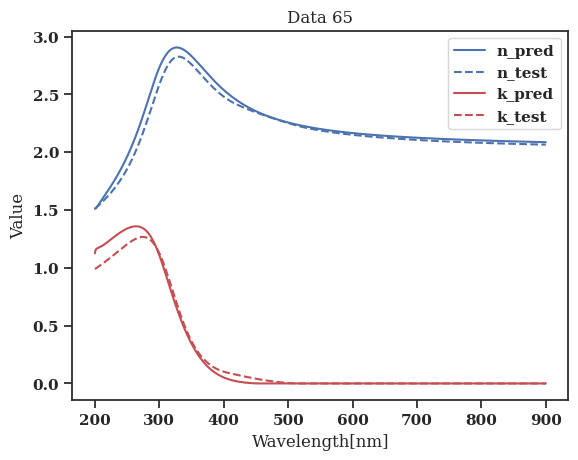

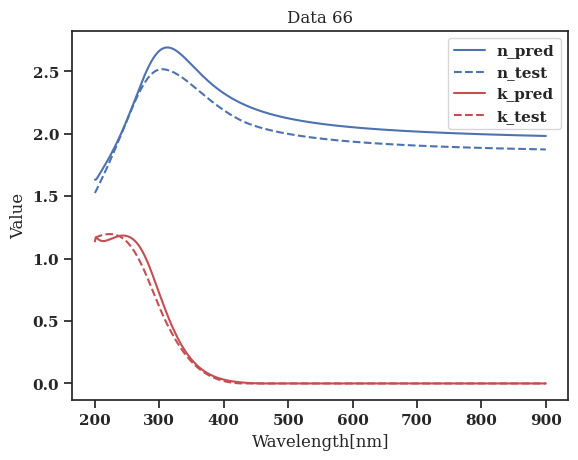

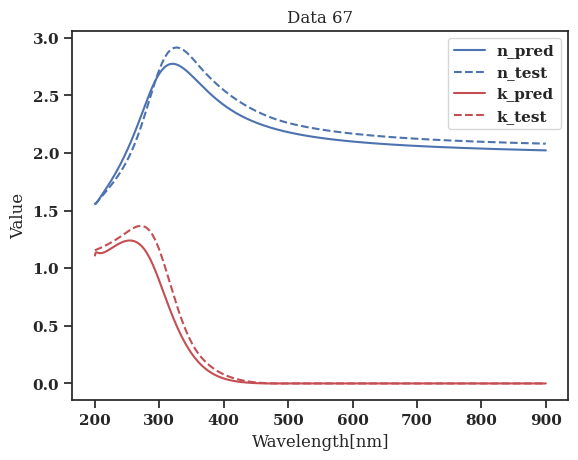

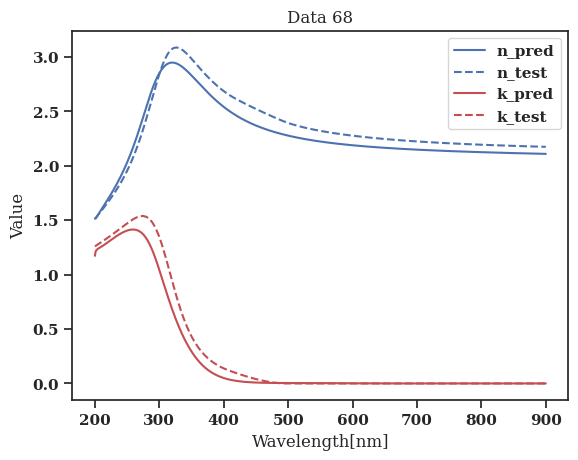

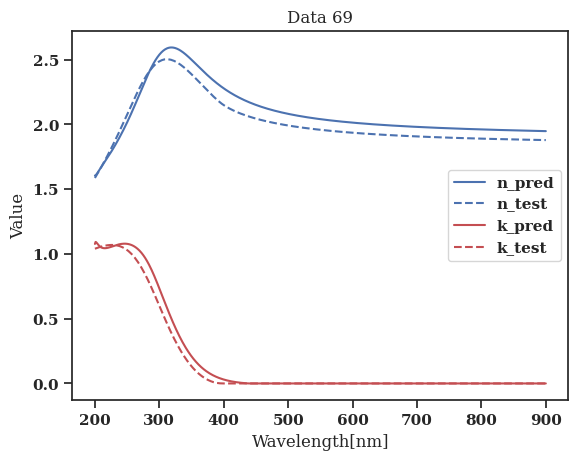

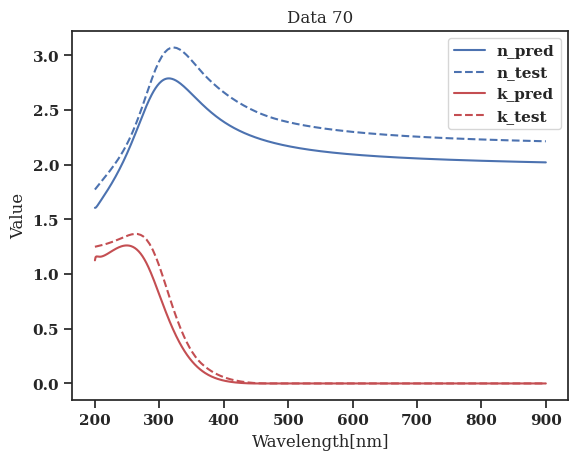

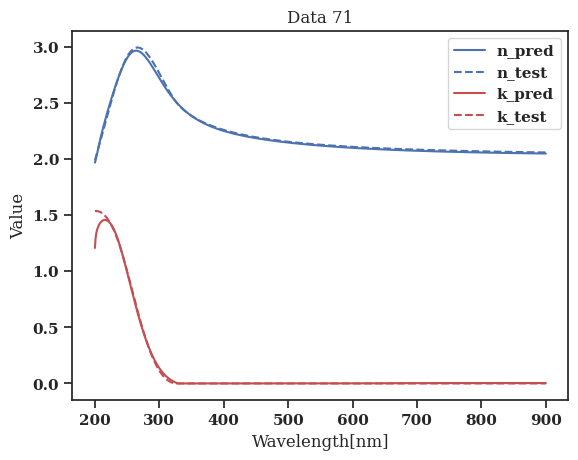

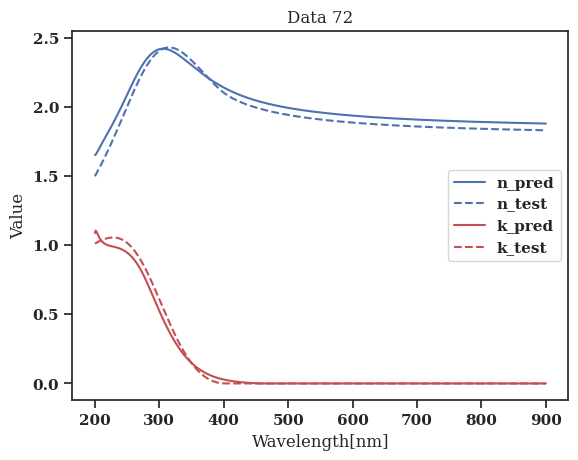

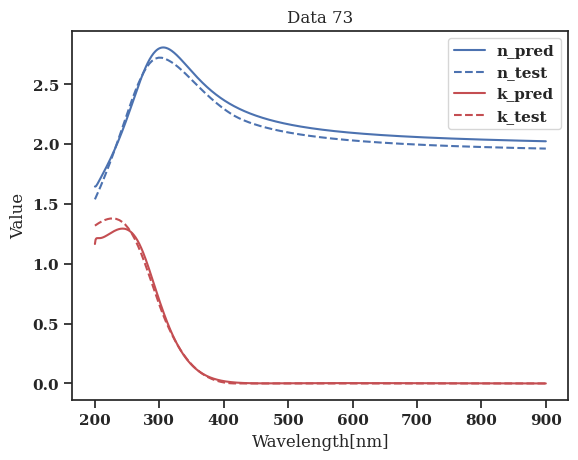

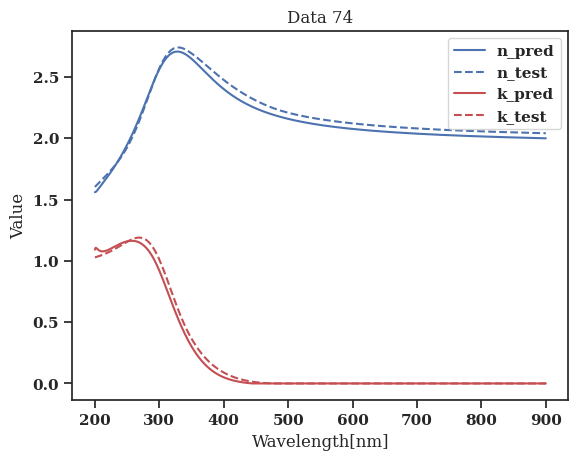

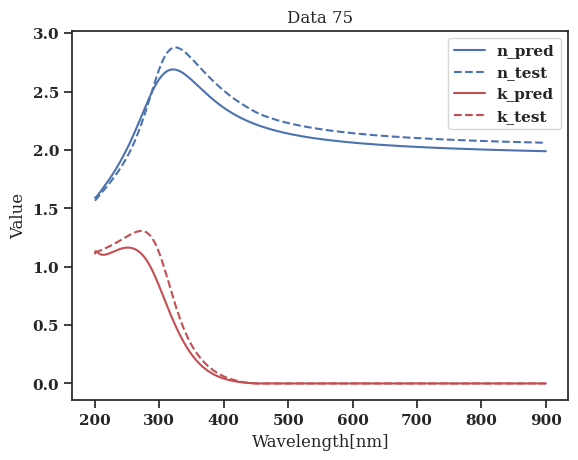

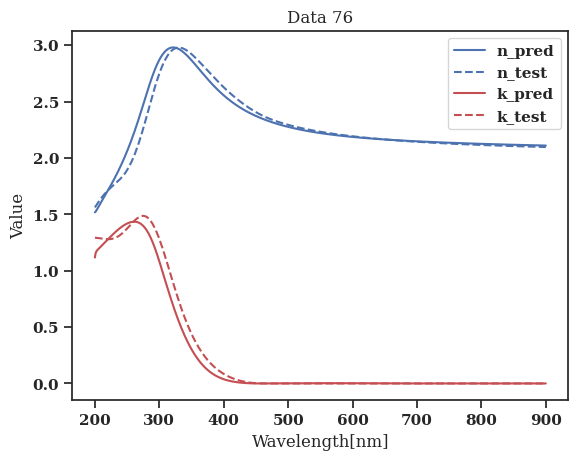

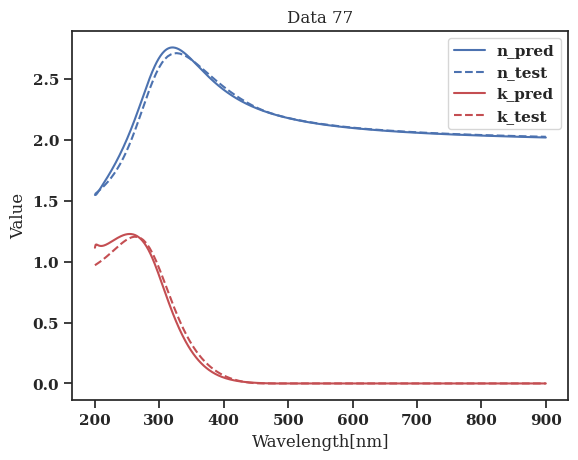

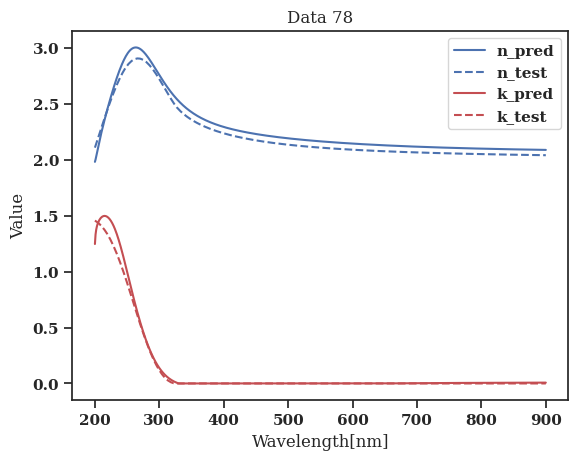

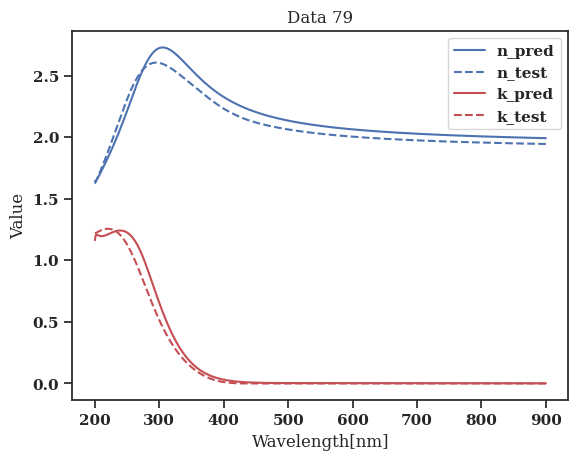

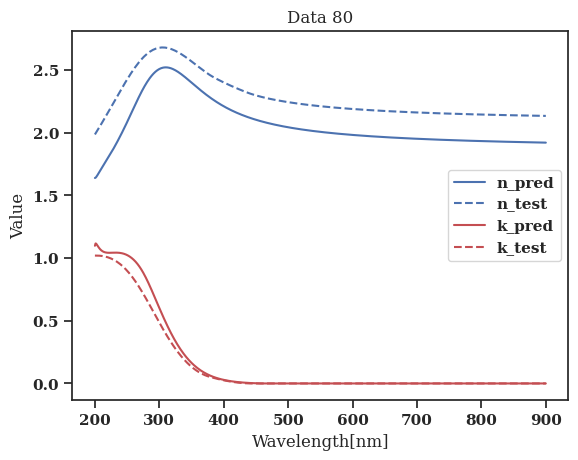

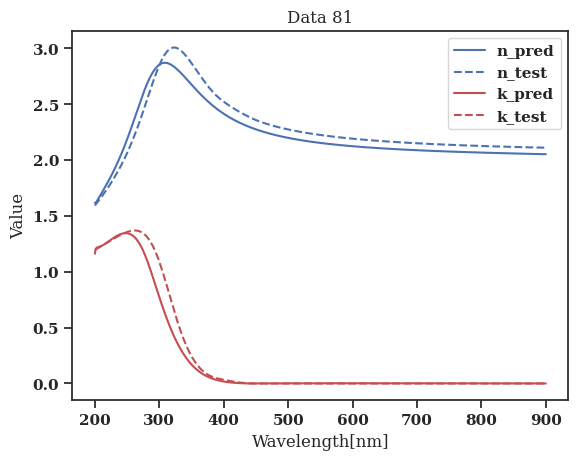

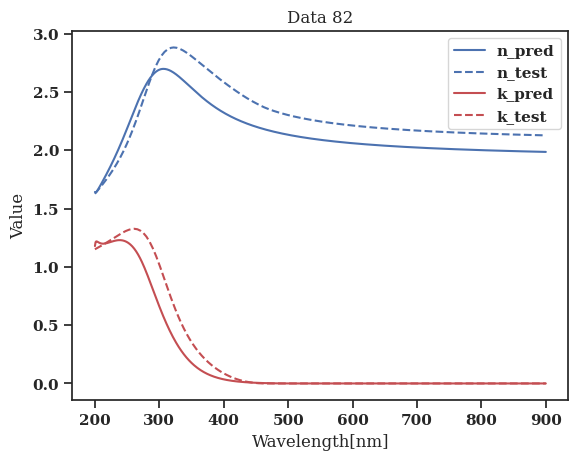

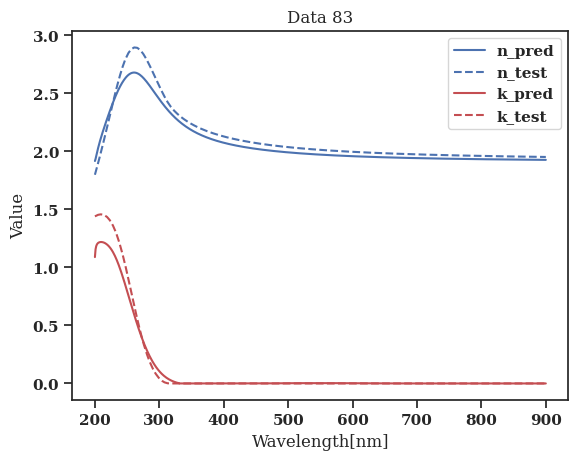

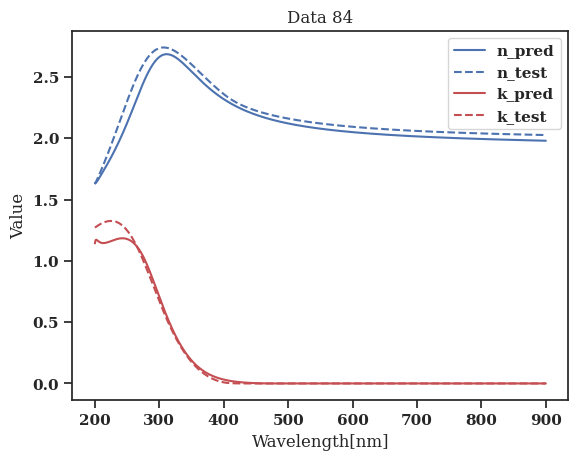

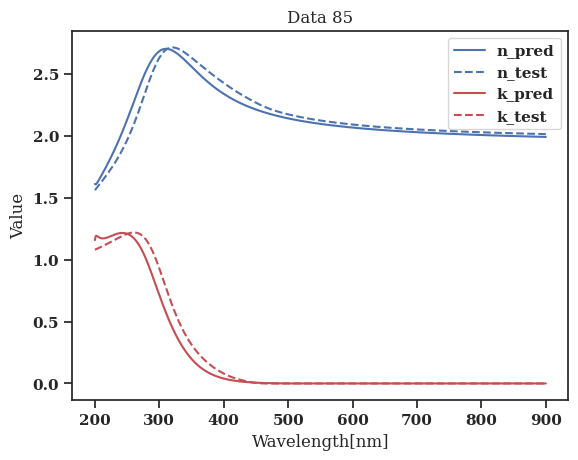

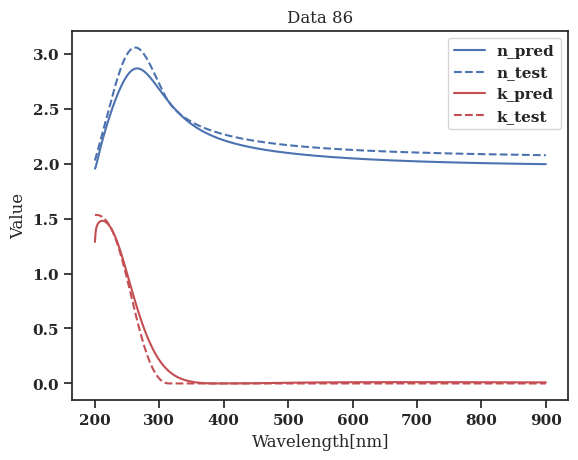

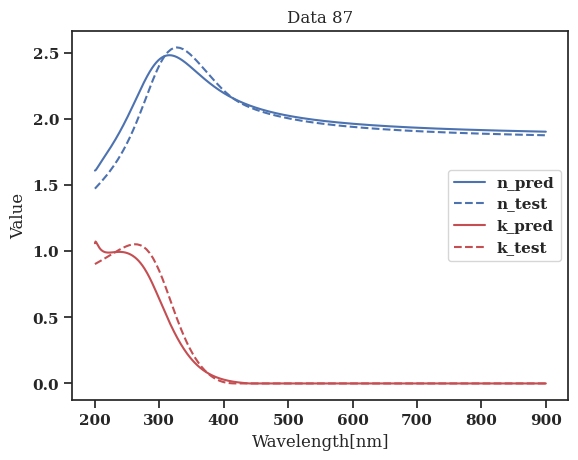

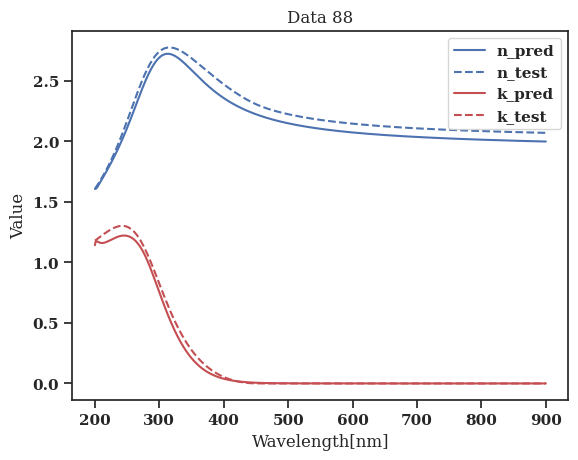

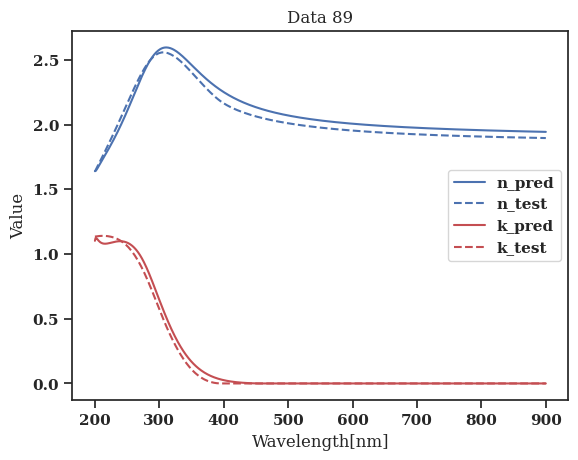

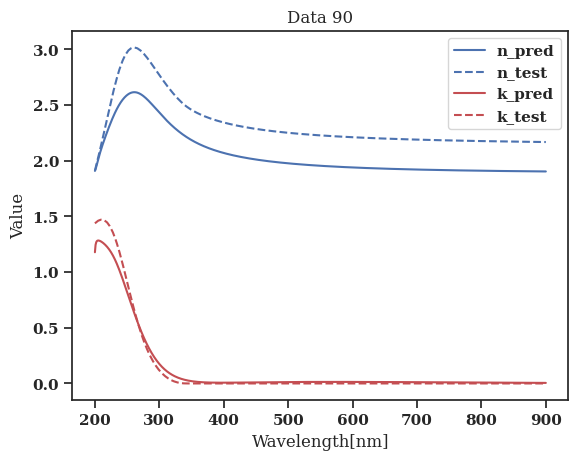

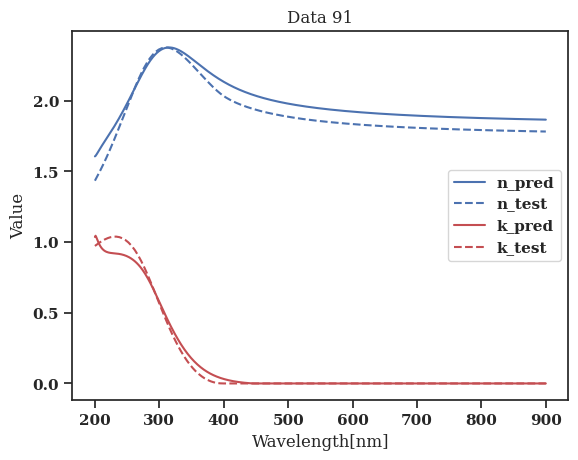

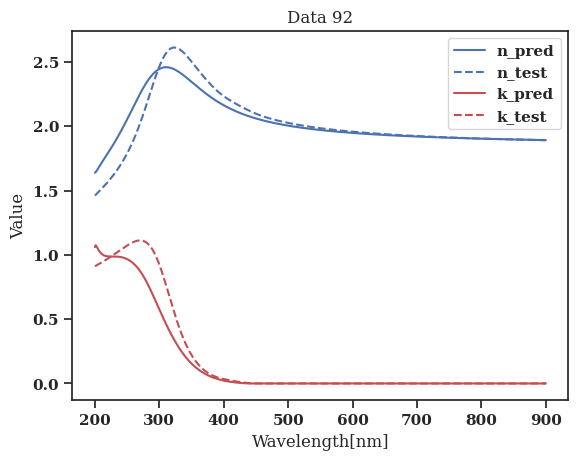

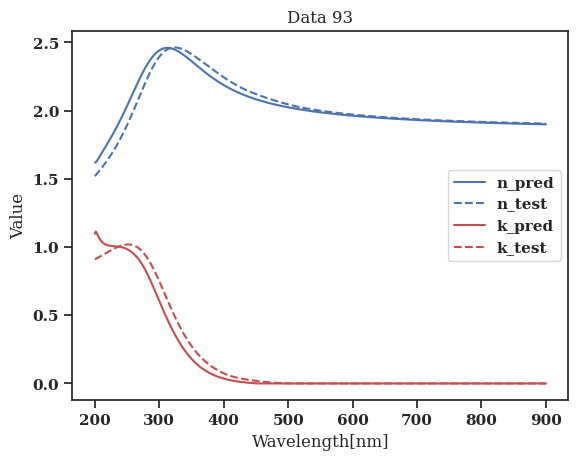

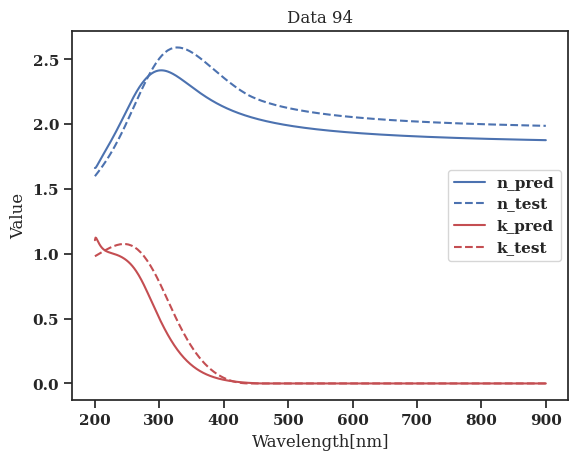

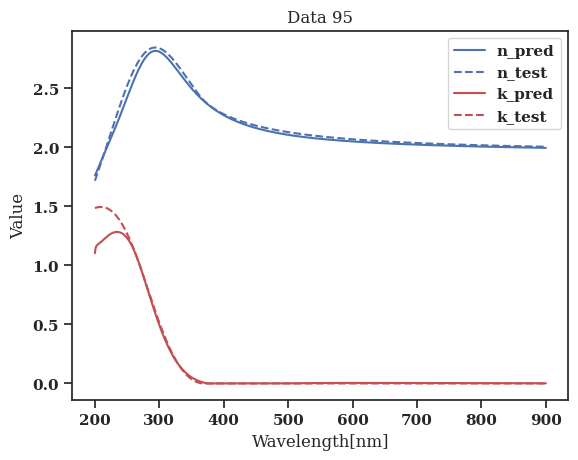

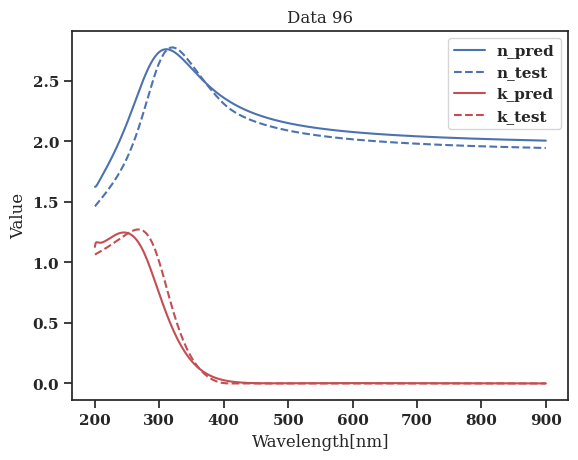

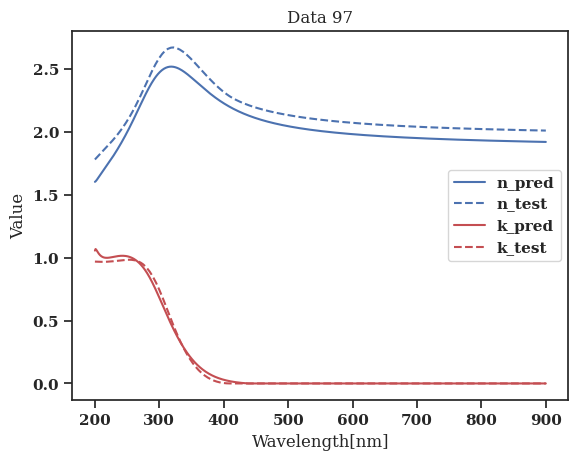

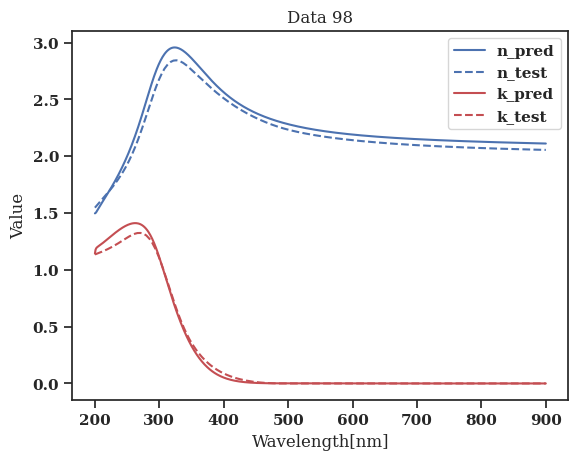

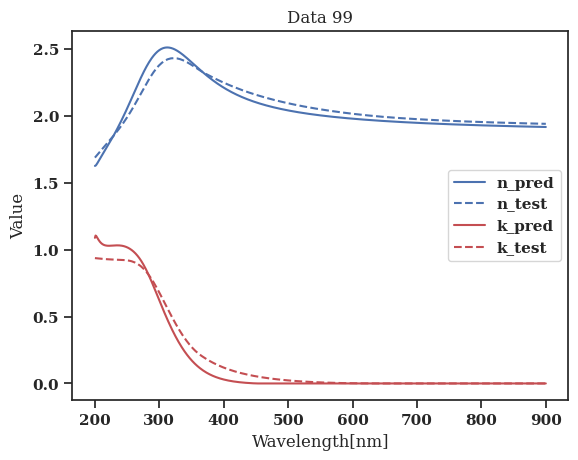

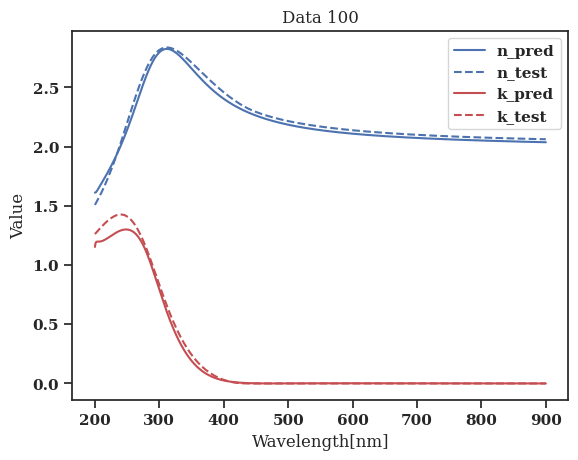

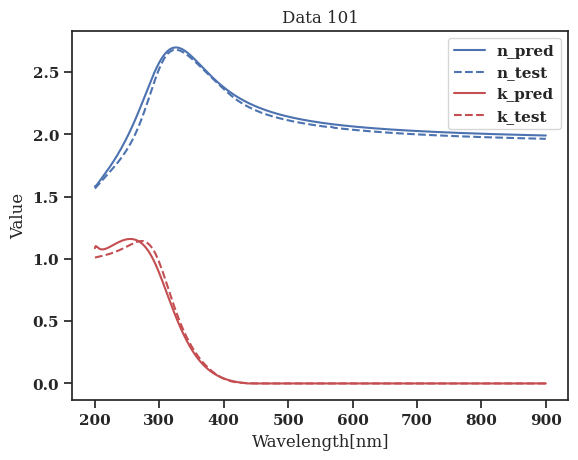

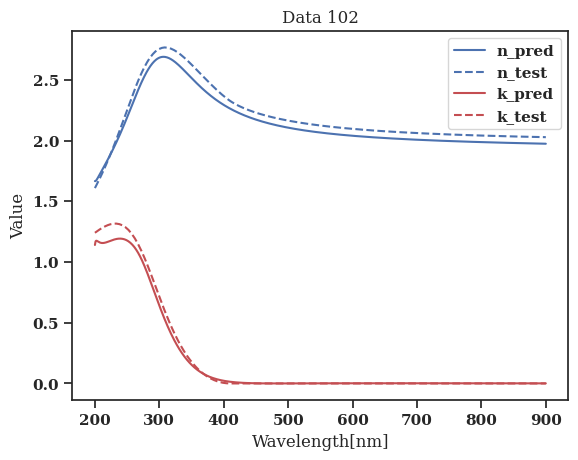

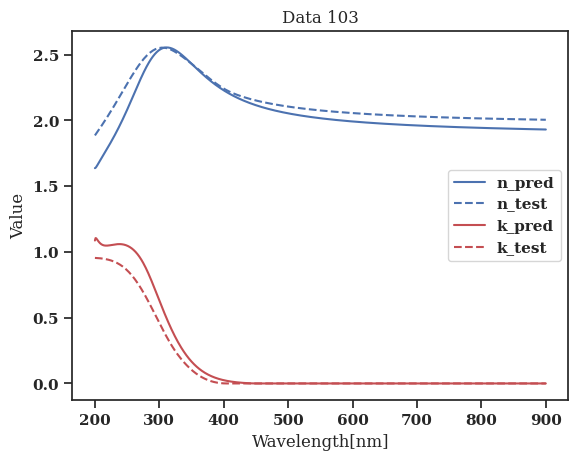

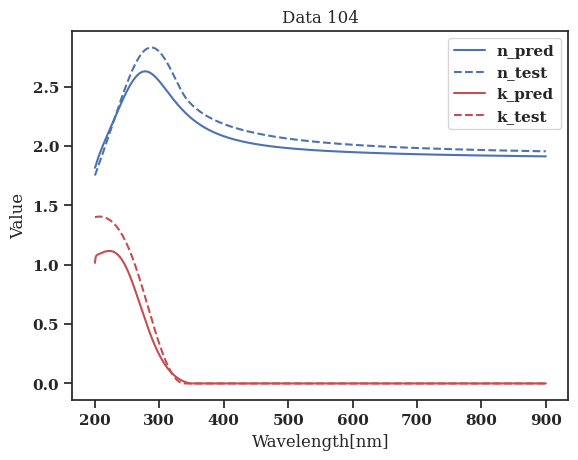

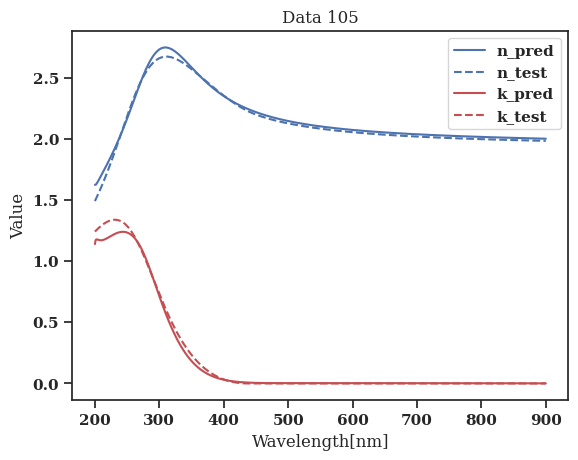

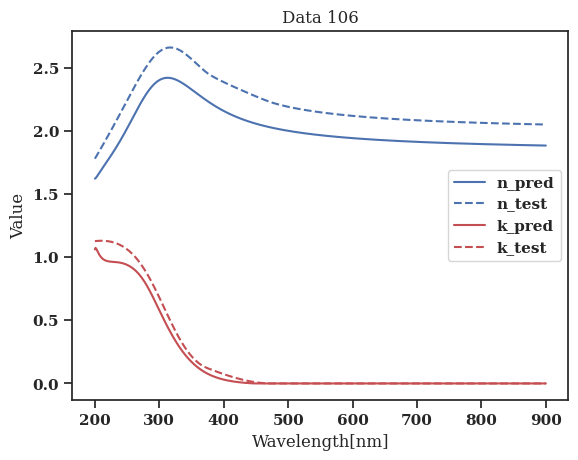

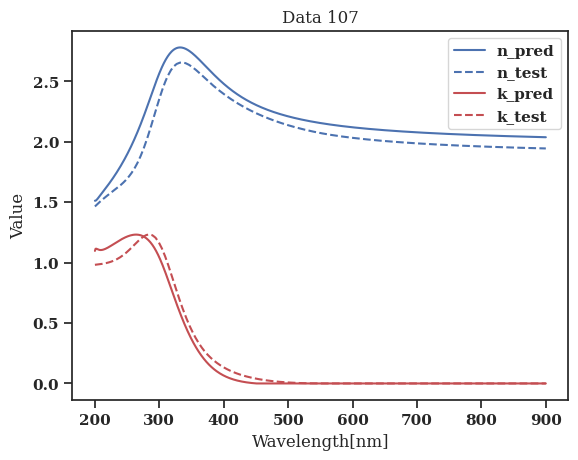

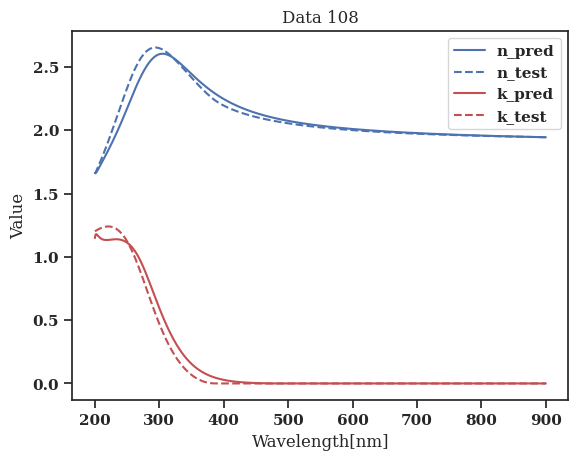

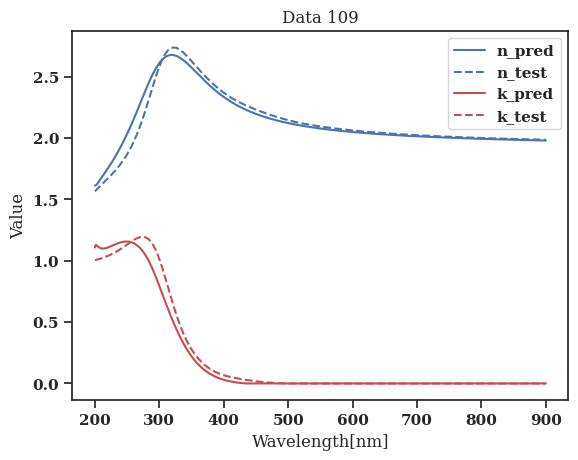

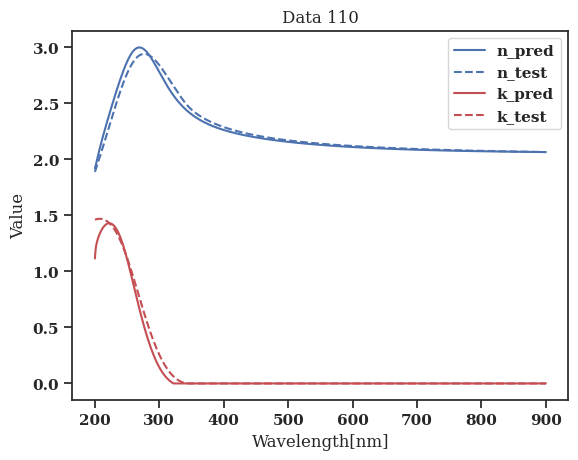

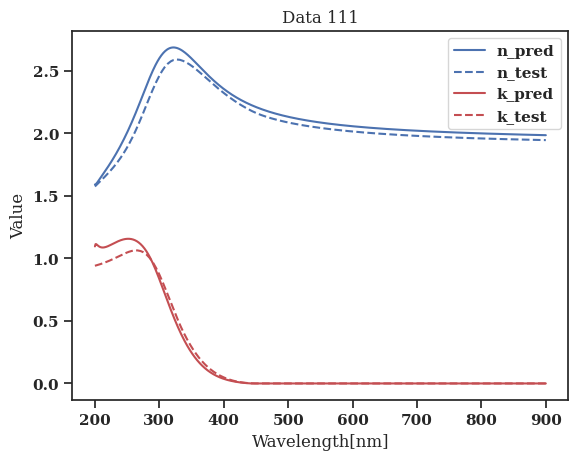

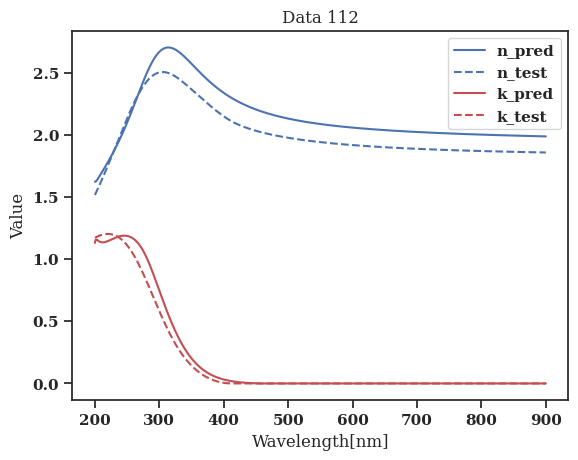

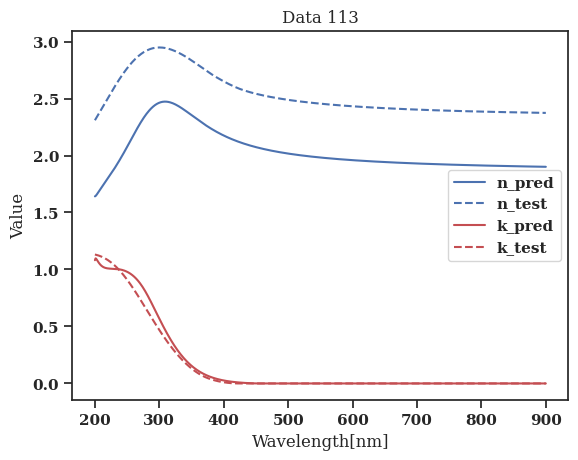

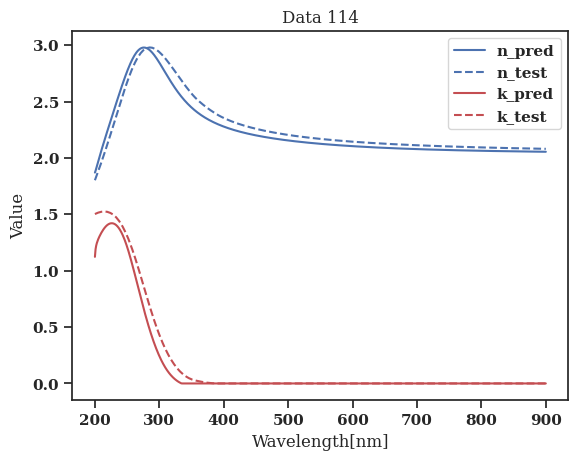

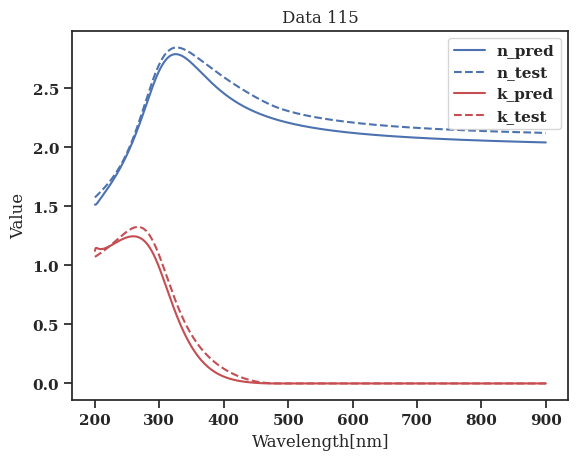

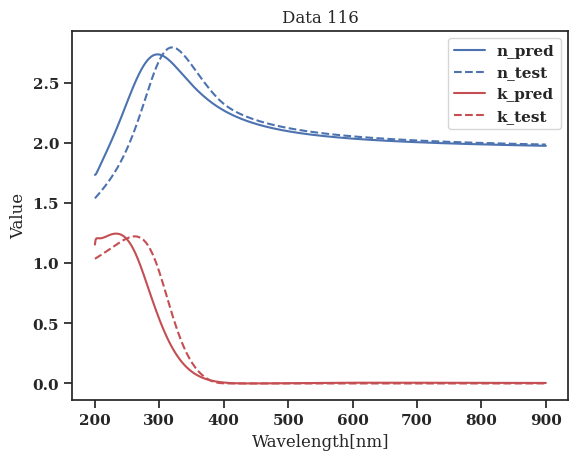

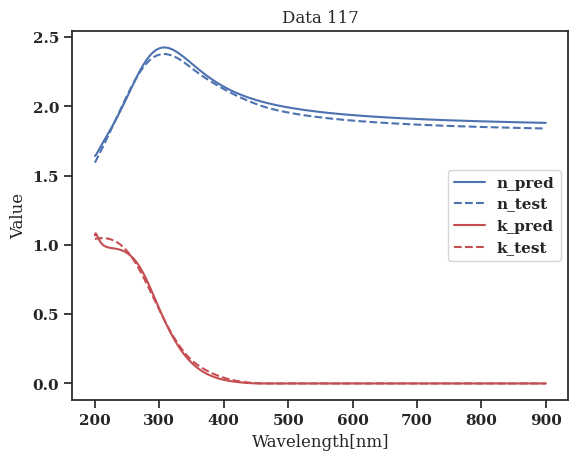

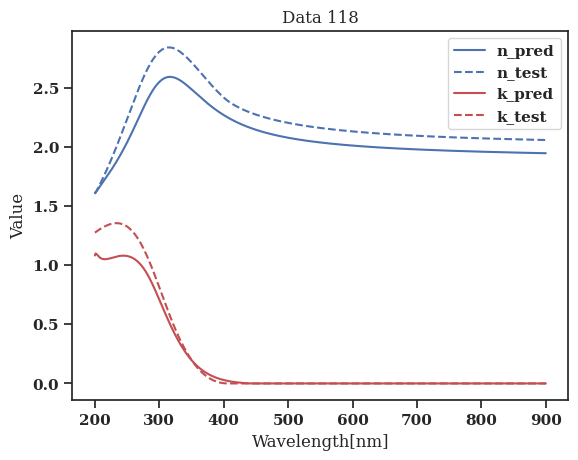

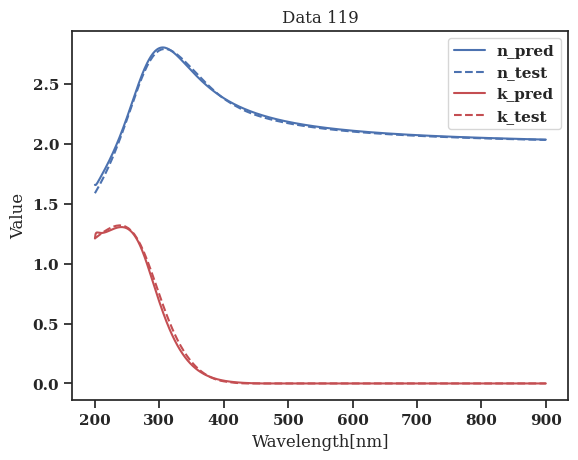

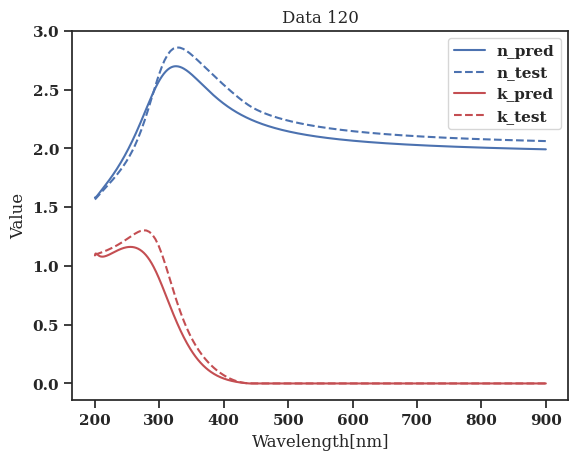

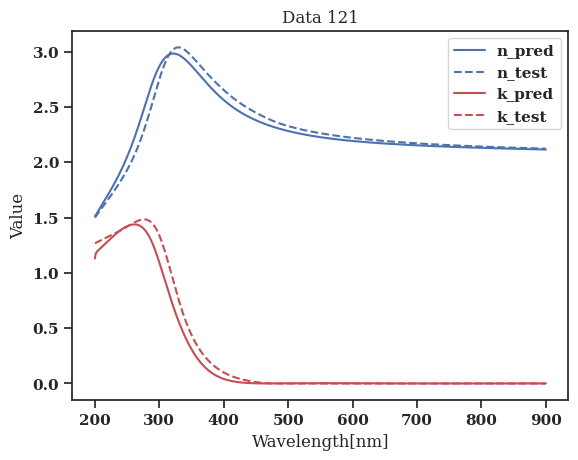

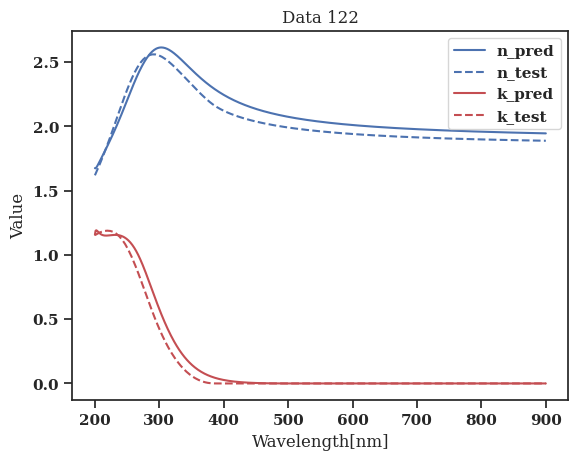

In [16]:
# Generate X-axis data
wavelength = range(200, 901)

# Go through 122 data and draw four curves
for i in range(122):
    plt.figure()
    plt.plot(wavelength, n_pred[i], 'b-', label='n_pred')
    plt.plot(wavelength, n_test[i], 'b--', label='n_test')
    plt.plot(wavelength, k_pred[i], 'r-', label='k_pred')
    plt.plot(wavelength, k_test[i], 'r--', label='k_test')
    
    plt.xlabel('Wavelength[nm]')
    plt.ylabel('Value')
    plt.title('Data {}'.format(i+1))
    plt.legend()
    plt.show()